In [1]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from scipy.stats import shapiro, skew, kurtosis, kruskal, chi2_contingency, probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv("./data/raw_data.csv")

### First look at the dataset

In [3]:
raw_data.head()

Vehicle condition                               Category  \
0                 Used vehicle                             Estate Car   
1                 Used vehicle                             Estate Car   
2                 Used vehicle  SUV / Off-road Vehicle / Pickup Truck   
3  Used vehicle, Accident-free                                 Saloon   
4                 Used vehicle                                 Saloon   

  Vehicle Number Availability          Origin     Mileage Cubic Capacity  \
0          0337D          Now  German edition  107,295 km      1,968 ccm   
1            NaN          NaN  German edition   98,844 km      1,984 ccm   
2          0326I          Now  German edition   83,181 km      1,984 ccm   
3            NaN          NaN             NaN   92,000 km      2,967 ccm   
4          0286H          Now  German edition  110,244 km      1,984 ccm   

             Power                  Drive type                 Fuel  ...  \
0  110 kW (150 hp)  Internal combustion engine               Diesel  ...   
1  185 kW (252 hp)  Internal combustion engine               Petrol  ...   
2  132 kW (179 hp)  Internal combustion engine  Petrol, E10-enabled  ...   
3  180 kW (245 hp)  Internal combustion engine               Diesel  ...   
4  140 kW (190 hp)  Internal combustion engine  Petrol, E10-enabled  ...   

   Fuel price Vehicle tax Construction Year Support load  \
0         NaN         NaN               NaN          NaN   
1         NaN         NaN               NaN          NaN   
2         NaN         NaN               NaN          NaN   
3         NaN         NaN               NaN          NaN   
4         NaN         NaN               NaN          NaN   

  Possible CO₂ costs over the next 10 years (15,000 km/year)2  \
0                                                NaN            
1                                                NaN            
2                                                NaN            
3                                                NaN            
4                                                NaN            

  Commercial, Export/Import Sliding door Battery capacity (in kWh) Battery  \
0                       NaN          NaN                       NaN     NaN   
1                       NaN          NaN                       NaN     NaN   
2                       NaN          NaN                       NaN     NaN   
3                       NaN          NaN                       NaN     NaN   
4                       NaN          NaN                       NaN     NaN   

  Other energy source  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 48 columns]

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 48 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Vehicle condition                                            4005 non-null   object 
 1   Category                                                     4005 non-null   object 
 2   Vehicle Number                                               2320 non-null   object 
 3   Availability                                                 1665 non-null   object 
 4   Origin                                                       2777 non-null   object 
 5   Mileage                                                      4005 non-null   object 
 6   Cubic Capacity                                               3996 non-null   object 
 7   Power                                                        4005 non-null   o

In [5]:
raw_data.describe()

Number of Seats  Number of Vehicle Owners    Cylinders  \
count      3942.000000               2989.000000  2468.000000   
mean          4.928463                  1.736032     4.019449   
std           0.631135                  0.679773     0.446155   
min           2.000000                  0.000000     3.000000   
25%           5.000000                  1.000000     4.000000   
50%           5.000000                  2.000000     4.000000   
75%           5.000000                  2.000000     4.000000   
max           9.000000                  5.000000     8.000000   

       Construction Year  
count         379.000000  
mean         2017.047493  
std             2.117666  
min          2006.000000  
25%          2016.000000  
50%          2017.000000  
75%          2018.000000  
max          2024.000000

## Conclusions after our first look at the dataset

* We have just over 4000 rows in out dataset, corresponding to 4000 listings, around 1000 for each of the 4 makes for which we performed the webscraping process
* We have just shy of 50 features. However these are all treated as strings ('object' type) since that is how they were extracted from the scraped HTML.
* We should also take note to the fact that many of these features have missing records, so we will need to analyze this in more detail.

### Cast Columns To Correct Data Types

In [6]:
# Clean Numeric Columns
def clean_numeric_column(column, remove_text=True):
    if remove_text:
        return column.str.replace(r"[^\d.]", "", regex=True).astype(float)
    return column

In [7]:
# Convert  columns to numeric
raw_data["price"] = clean_numeric_column(raw_data["price"])
raw_data["Mileage"] = clean_numeric_column(raw_data["Mileage"])
raw_data["Cubic Capacity"] = clean_numeric_column(raw_data["Cubic Capacity"])
raw_data["Power"] = raw_data["Power"].str.extract(r"(\d+)", expand=False).astype(float)

In [8]:
# We're also going to save the cleaned data to a csv file to use in the app
raw_data.to_csv("./data/raw_data_cast.csv", index=False)

### Missing Records Analysis

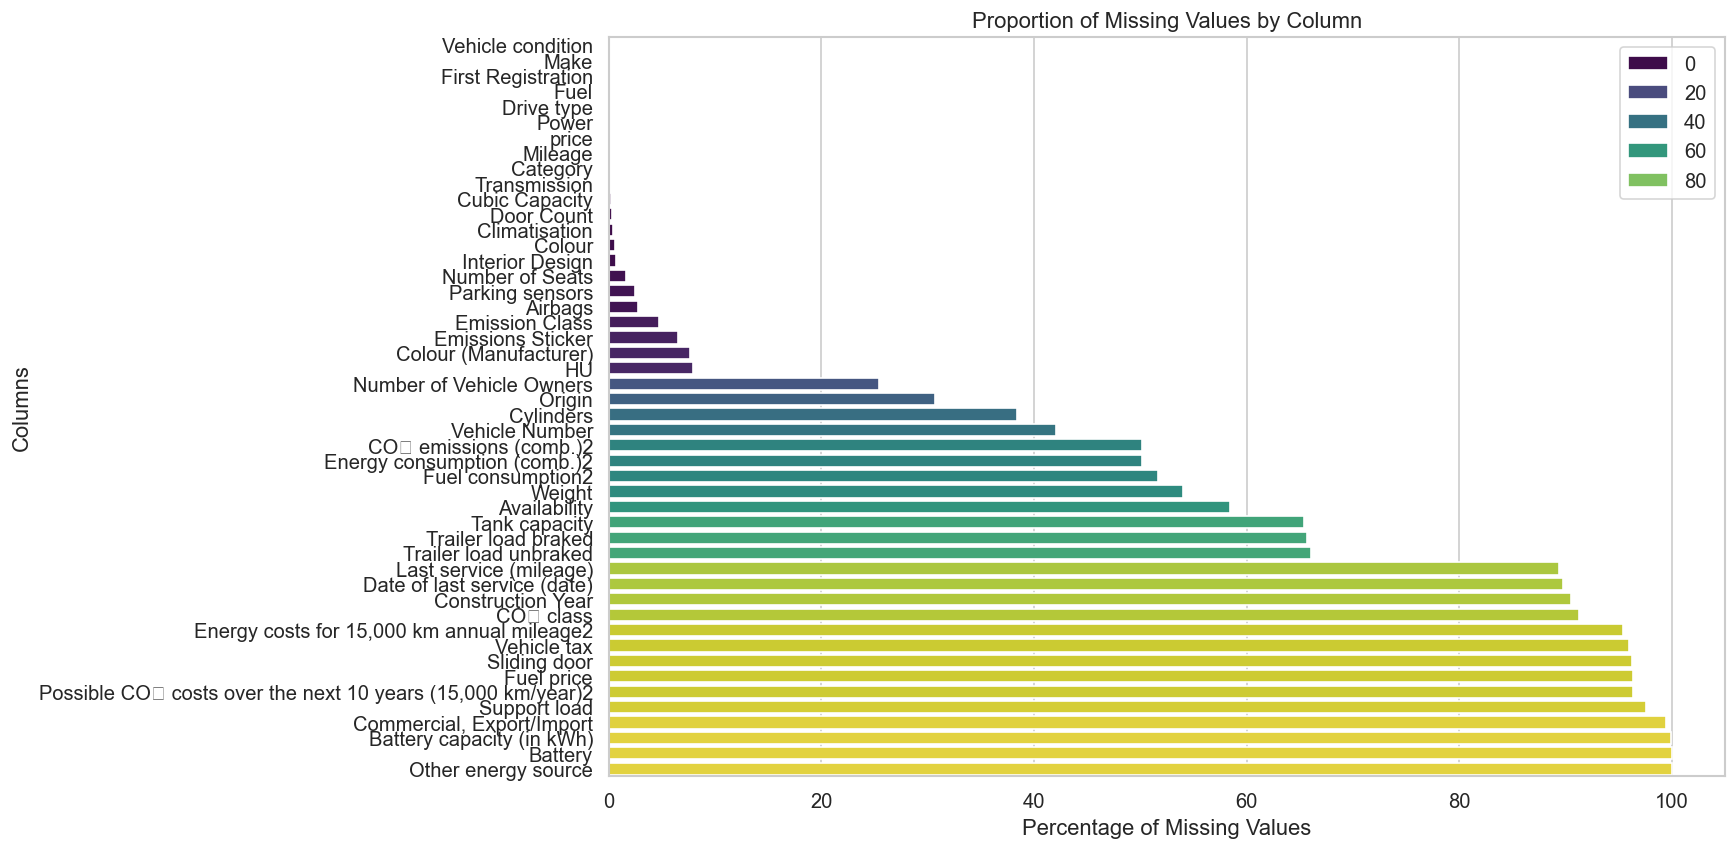

In [9]:
# Calculate the proportion of missing values
missing_values = (raw_data.isnull().sum() / len(raw_data)) * 100
missing_values = missing_values.sort_values(ascending=True)

# Plot the missing values
plt.figure(figsize=(12, 8))
sns.barplot(
    x=missing_values.values,
    y=missing_values.index,
    palette="viridis",
    hue=missing_values.values,
)
plt.title("Proportion of Missing Values by Column")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.show()

<Figure size 1440x480 with 0 Axes>

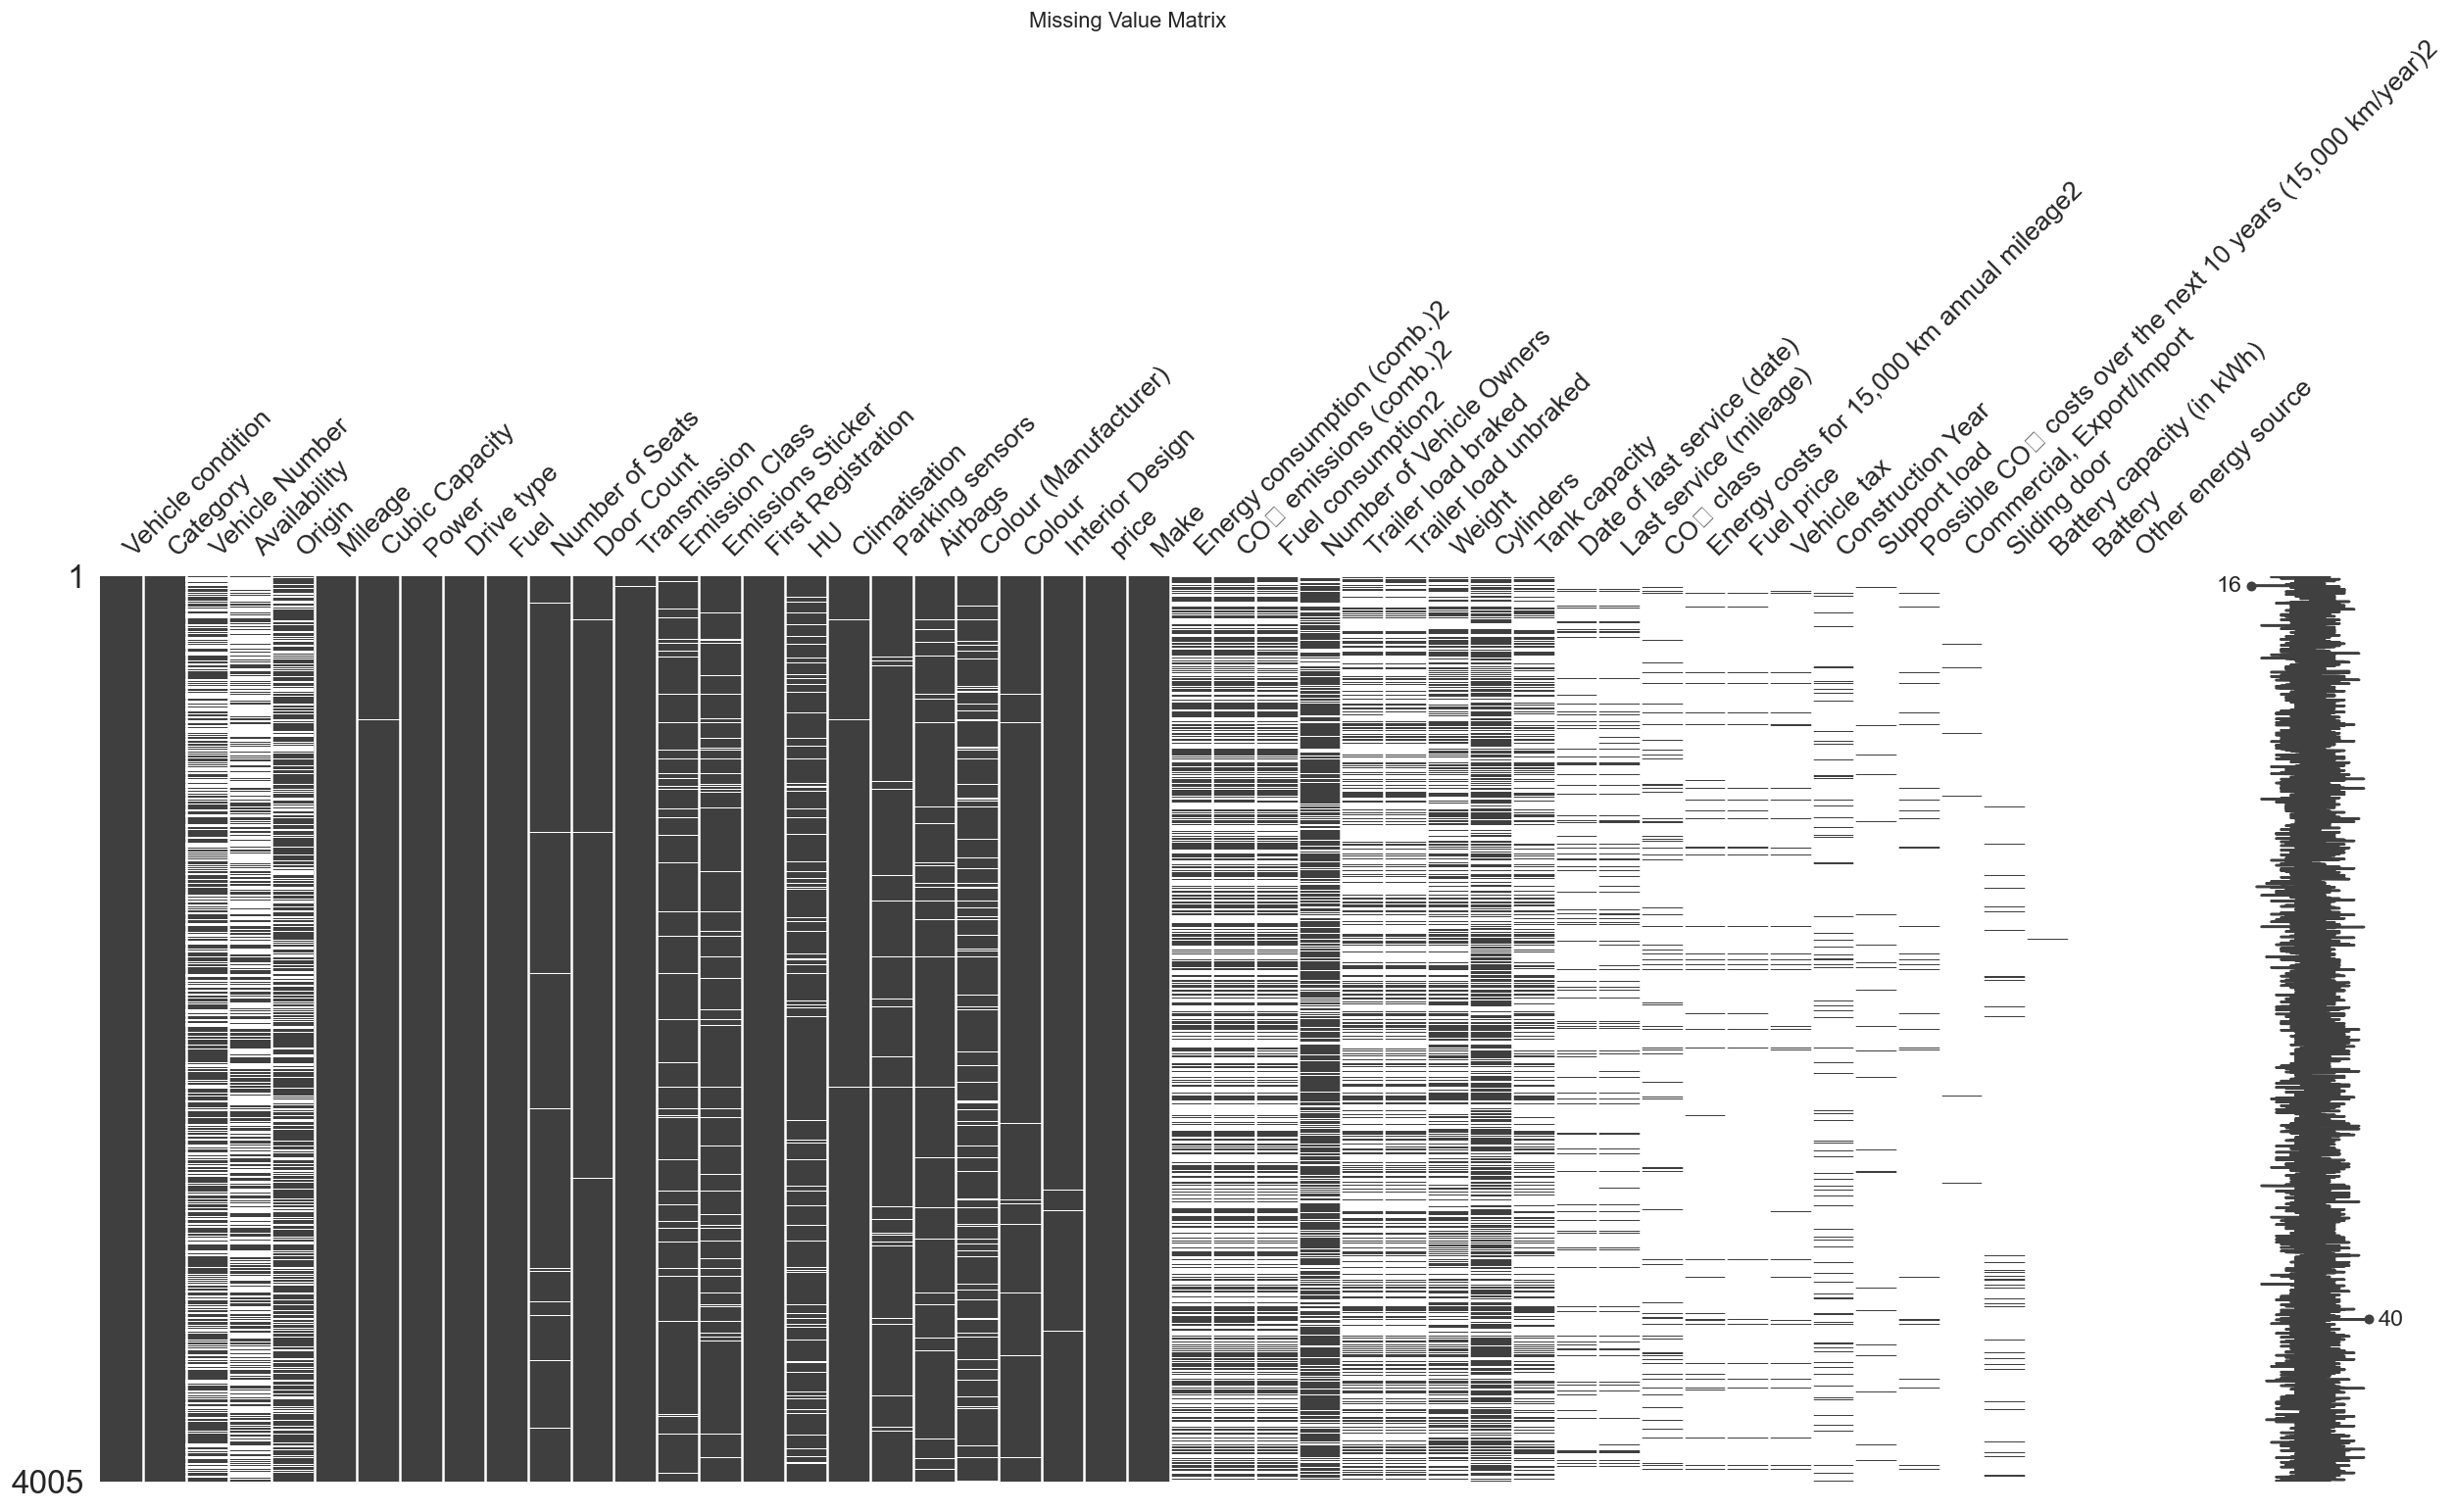

<Figure size 1200x480 with 0 Axes>

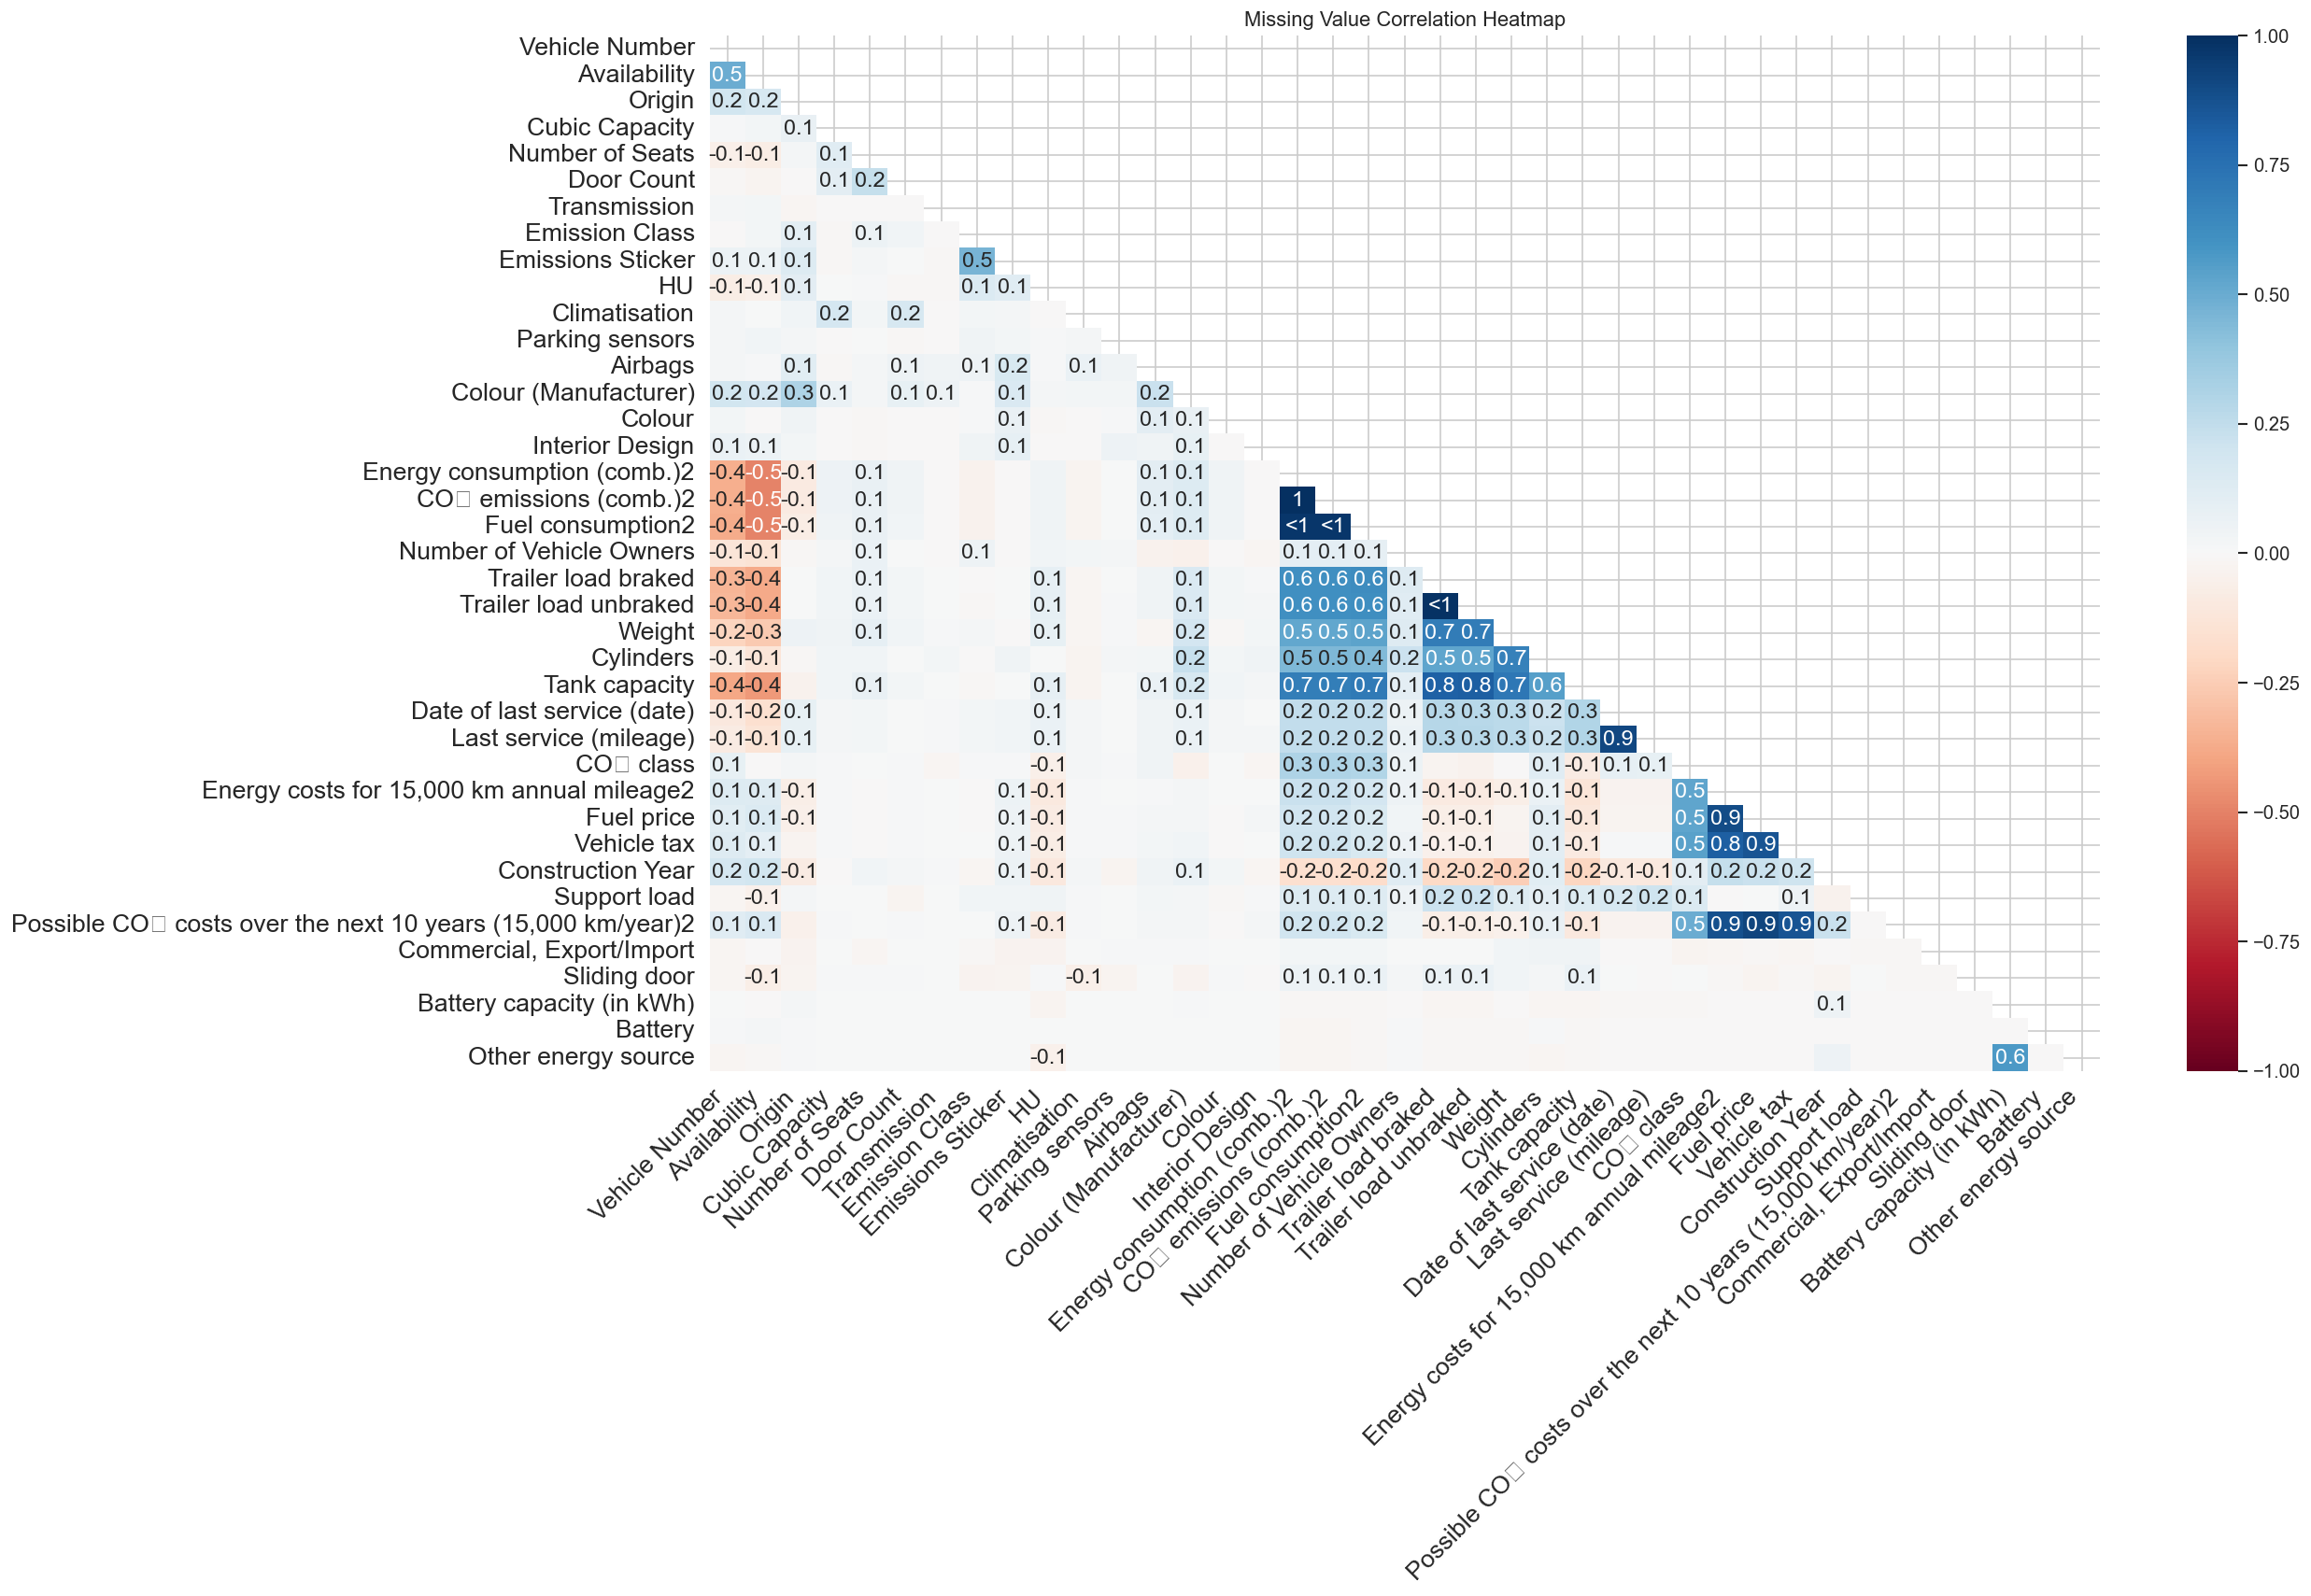

In [10]:
plt.figure(figsize=(12, 4))
msno.matrix(raw_data)
plt.title("Missing Value Matrix")
plt.show()

plt.figure(figsize=(10, 4))
msno.heatmap(raw_data)
plt.title("Missing Value Correlation Heatmap")
plt.show()

In [11]:
# Drop columns with more than 50% missing values
threshold = 50
columns_to_drop = missing_values[missing_values > threshold].index.tolist()
print(f"Columns with more than {threshold}% missing values: {columns_to_drop}")

raw_data_cleaned = raw_data.drop(columns=columns_to_drop, axis=1)

print("\nCleaned Data Information:")
raw_data_cleaned.info()

Columns with more than 50% missing values: ['CO₂ emissions (comb.)2', 'Energy consumption (comb.)2', 'Fuel consumption2', 'Weight', 'Availability', 'Tank capacity', 'Trailer load braked', 'Trailer load unbraked', 'Last service (mileage)', 'Date of last service (date)', 'Construction Year', 'CO₂ class', 'Energy costs for 15,000 km annual mileage2', 'Vehicle tax', 'Sliding door', 'Fuel price', 'Possible CO₂ costs over the next 10 years (15,000 km/year)2', 'Support load', 'Commercial, Export/Import', 'Battery capacity (in kWh)', 'Battery', 'Other energy source']

Cleaned Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Vehicle condition         4005 non-null   object 
 1   Category                  4005 non-null   object 
 2   Vehicle Number            2320 non-null   object 
 3   Origin              

In [12]:
# Get unique values for categorical columns
categorical_columns = raw_data_cleaned.select_dtypes(include="object").columns
for col in categorical_columns:
    unique_values = raw_data_cleaned[col].nunique()
    print(f"{col}: {unique_values} unique values")

Vehicle condition: 4 unique values
Category: 10 unique values
Vehicle Number: 2215 unique values
Origin: 2 unique values
Drive type: 2 unique values
Fuel: 7 unique values
Door Count: 3 unique values
Transmission: 2 unique values
Emission Class: 7 unique values
Emissions Sticker: 3 unique values
First Registration: 157 unique values
HU: 47 unique values
Climatisation: 6 unique values
Parking sensors: 60 unique values
Airbags: 4 unique values
Colour (Manufacturer): 815 unique values
Colour: 25 unique values
Interior Design: 39 unique values
Make: 4 unique values


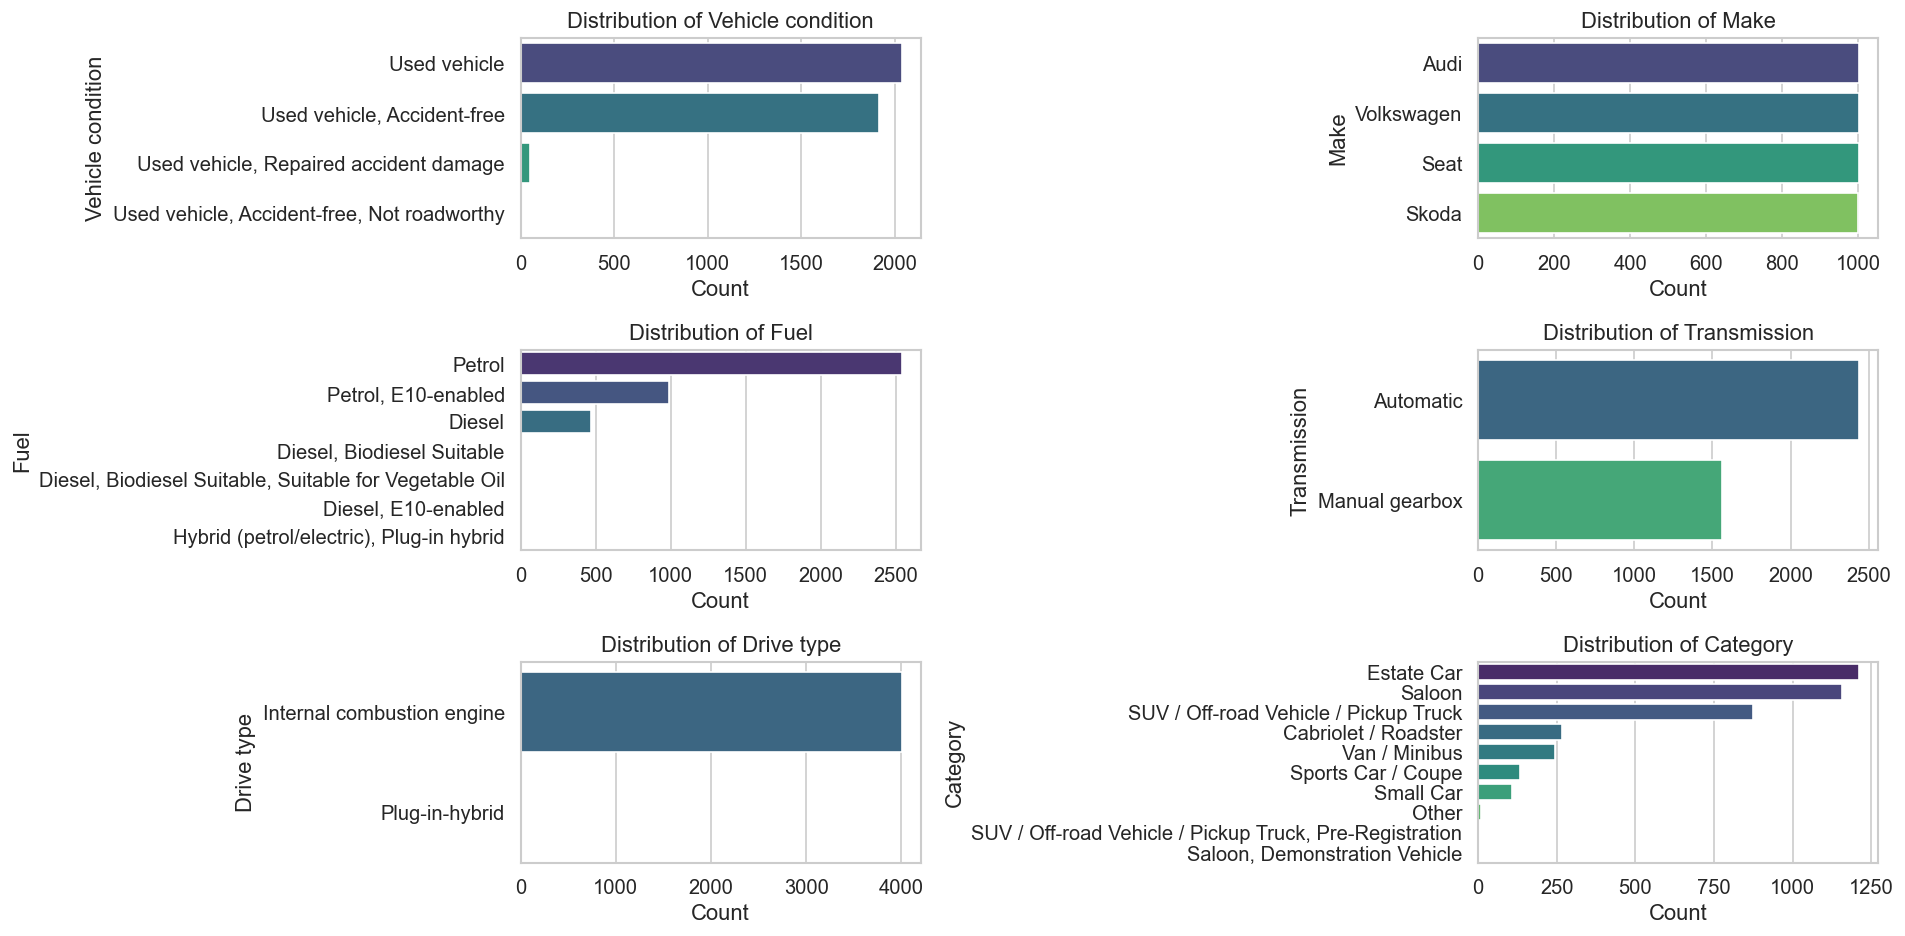

In [13]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(
    ["Vehicle condition", "Make", "Fuel", "Transmission", "Drive type", "Category"],
    start=1,
):
    plt.subplot(3, 2, i)
    sns.countplot(
        y=raw_data_cleaned[col],
        order=raw_data_cleaned[col].value_counts().index,
        palette="viridis",
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [14]:
# Drop the 'Drive type' column since it has only one unique value
raw_data_cleaned = raw_data_cleaned.drop(columns=["Drive type"], axis=1)

# Remove records in which "Vehicle condition" is "Used vehicle, Accident-free, Not roadworthy"
# since there are few of them and they are outliers
raw_data_cleaned = raw_data_cleaned[
    raw_data_cleaned["Vehicle condition"]
    != "Used vehicle, Accident-free, Not roadworthy"
]

# Keep only the top 3 most commen "Fuel" types (Petrol, Petrol E10-enabled and Diesel)
raw_data_cleaned = raw_data_cleaned[
    raw_data_cleaned["Fuel"].isin(["Petrol", "Petrol E10-enabled", "Diesel"])
]

In [15]:
# Missing value imputation for important columns
raw_data_cleaned["Cubic Capacity"].fillna(
    raw_data_cleaned["Cubic Capacity"].median(), inplace=True
)
raw_data_cleaned["Power"].fillna(raw_data_cleaned["Power"].median(), inplace=True)
raw_data_cleaned["Number of Seats"].fillna(
    raw_data_cleaned["Number of Seats"].mode()[0], inplace=True
)

# Drop rows with missing values in critical columns (e.g., 'price', 'Mileage')
raw_data_cleaned = raw_data_cleaned.dropna(subset=["price", "Mileage"])

# Confirm that missing values are handled
print("\nRemaining Missing Values:")
print(raw_data_cleaned.isnull().sum())


Remaining Missing Values:
Vehicle condition              0
Category                       0
Vehicle Number              1416
Origin                      1072
Mileage                        0
Cubic Capacity                 0
Power                          0
Fuel                           0
Number of Seats                0
Door Count                     6
Transmission                   1
Emission Class               168
Emissions Sticker            235
First Registration             0
HU                           266
Climatisation                 14
Parking sensors               73
Airbags                      101
Colour (Manufacturer)        280
Colour                        19
Interior Design               20
price                          0
Make                           0
Number of Vehicle Owners     698
Cylinders                   1108
dtype: int64


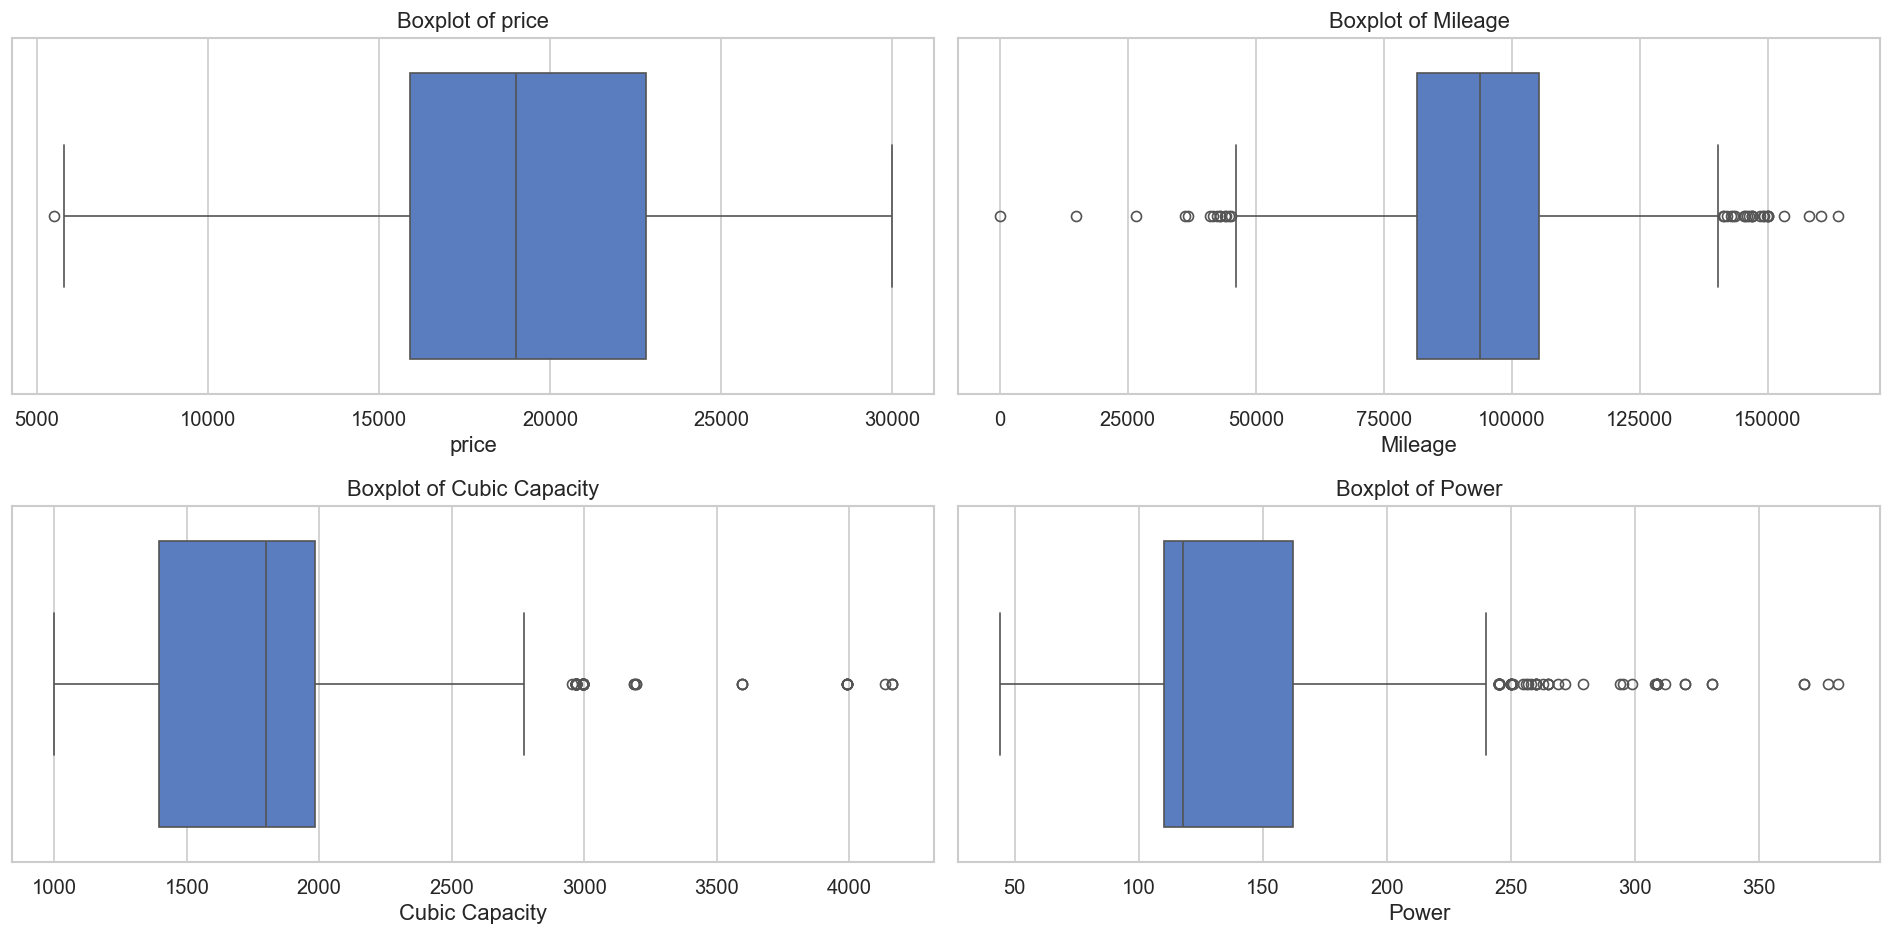

In [16]:
# Boxplots to identify outliers in numeric columns
numeric_columns = ["price", "Mileage", "Cubic Capacity", "Power"]
plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=raw_data_cleaned, x=col)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

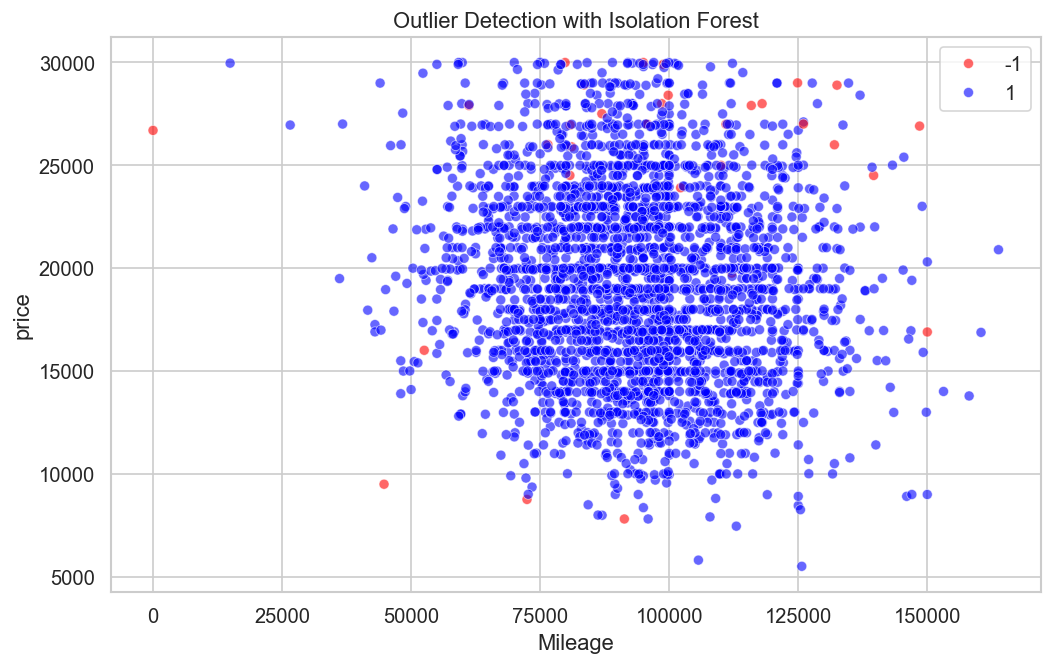

In [17]:
# Isolation Forest Outlier Detection (Mileage and Price)
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(raw_data_cleaned[numeric_columns])
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=raw_data_cleaned["Mileage"],
    y=raw_data_cleaned["price"],
    hue=outliers,
    palette={1: "blue", -1: "red"},
    alpha=0.6,
)
plt.title("Outlier Detection with Isolation Forest")
plt.show()

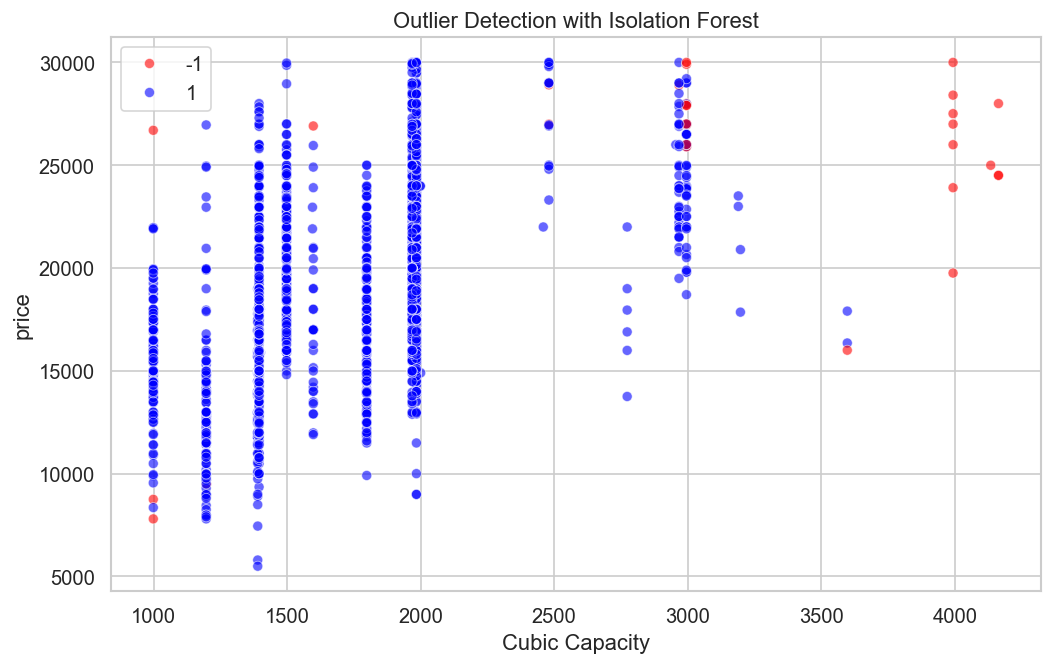

In [18]:
# Outlier Detection with Isolation Forest (Cubic Capacity and Price)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=raw_data_cleaned["Cubic Capacity"],
    y=raw_data_cleaned["price"],
    hue=outliers,
    palette={1: "blue", -1: "red"},
    alpha=0.6,
)
plt.title("Outlier Detection with Isolation Forest")
plt.show()

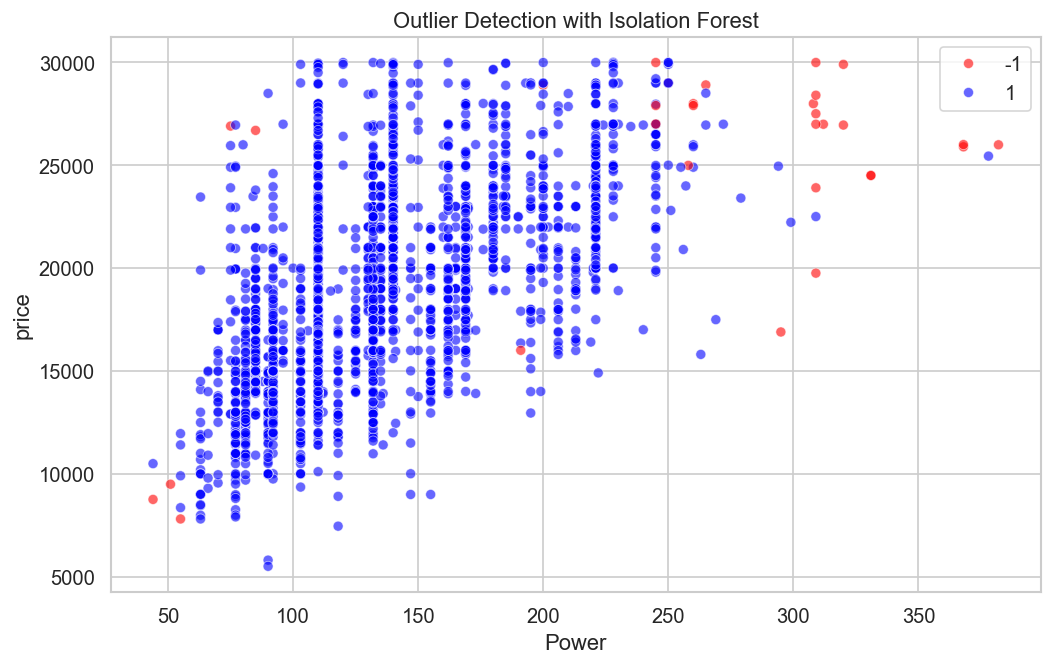

In [19]:
# Outlier Detection with Isolation Forest (Power and Price)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=raw_data_cleaned["Power"],
    y=raw_data_cleaned["price"],
    hue=outliers,
    palette={1: "blue", -1: "red"},
    alpha=0.6,
)
plt.title("Outlier Detection with Isolation Forest")
plt.show()

In [20]:
# Drop outliers
raw_data_cleaned = raw_data_cleaned[outliers == 1]

In [21]:
# Save the cleaned dataset to a CSV file
raw_data_cleaned.to_csv("./data/cleaned_data.csv", index=False)

## Univariate Analysis

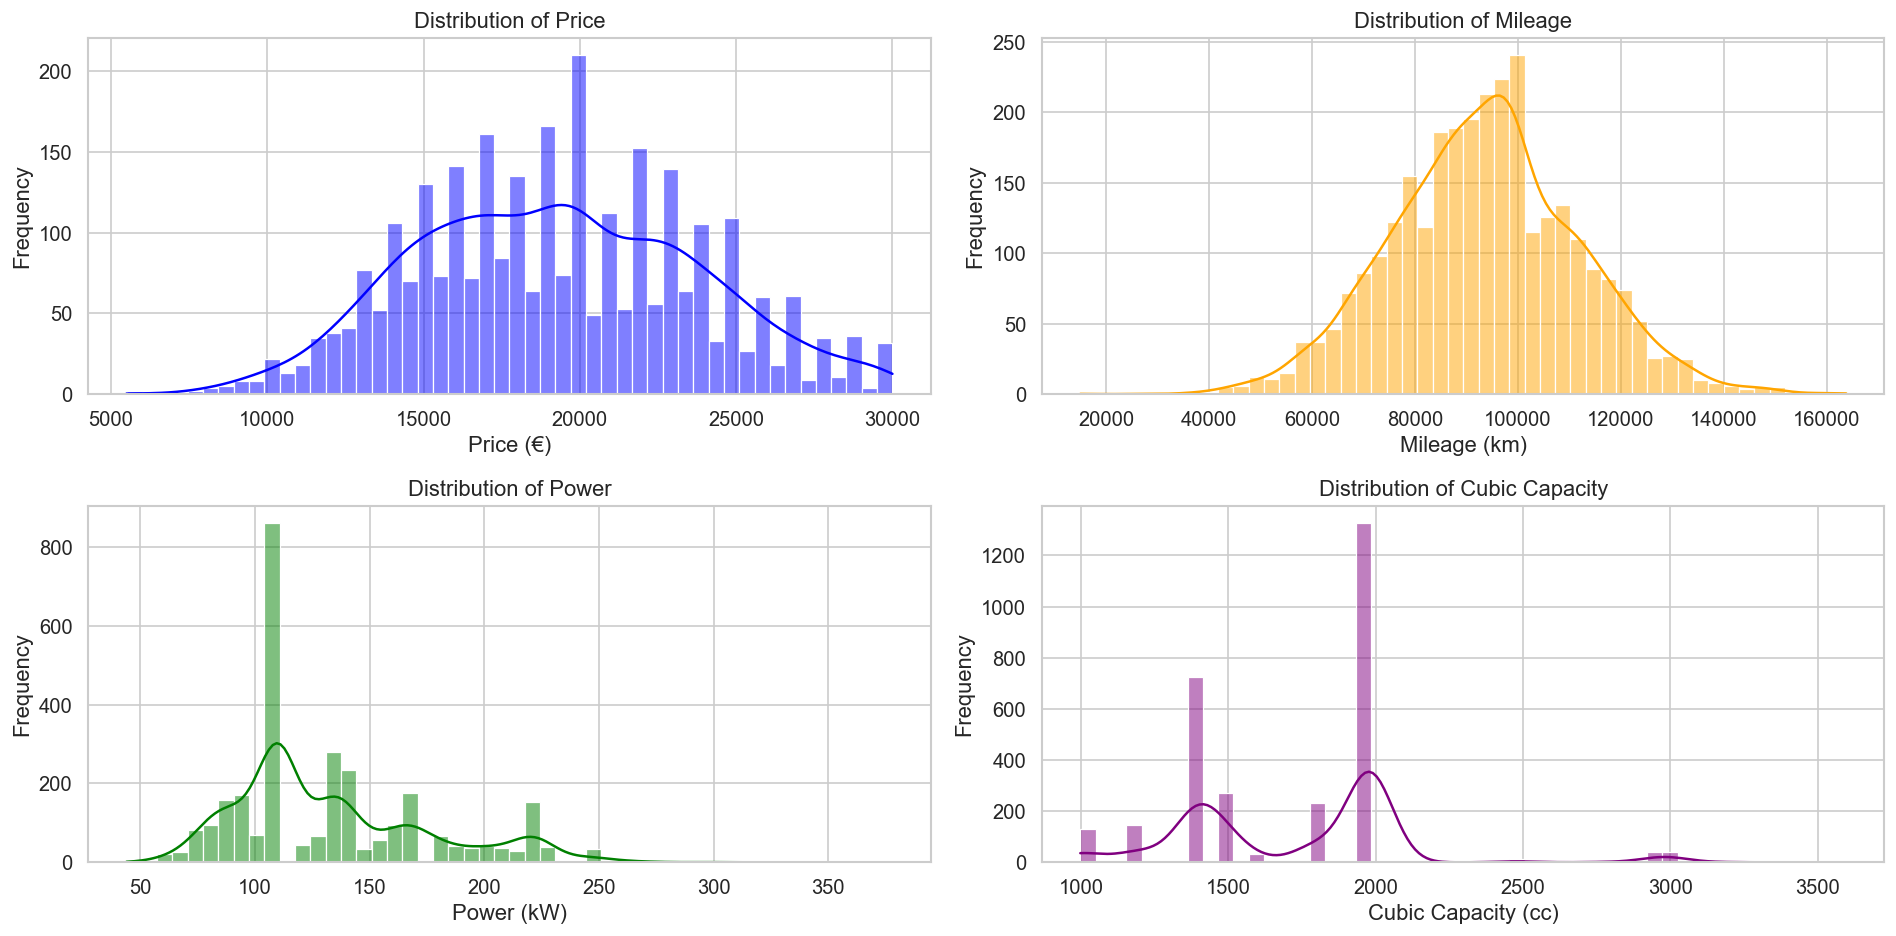

In [22]:
# Univariate Analysis for Key Numeric Features
plt.figure(figsize=(16, 8))

# Price Distribution
plt.subplot(2, 2, 1)
sns.histplot(raw_data_cleaned["price"], bins=50, kde=True, color="blue")
plt.title("Distribution of Price")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")

# Mileage Distribution
plt.subplot(2, 2, 2)
sns.histplot(raw_data_cleaned["Mileage"], bins=50, kde=True, color="orange")
plt.title("Distribution of Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Frequency")

# Power Distribution
plt.subplot(2, 2, 3)
sns.histplot(raw_data_cleaned["Power"], bins=50, kde=True, color="green")
plt.title("Distribution of Power")
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")

# Cubic Capacity Distribution
plt.subplot(2, 2, 4)
sns.histplot(raw_data_cleaned["Cubic Capacity"], bins=50, kde=True, color="purple")
plt.title("Distribution of Cubic Capacity")
plt.xlabel("Cubic Capacity (cc)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

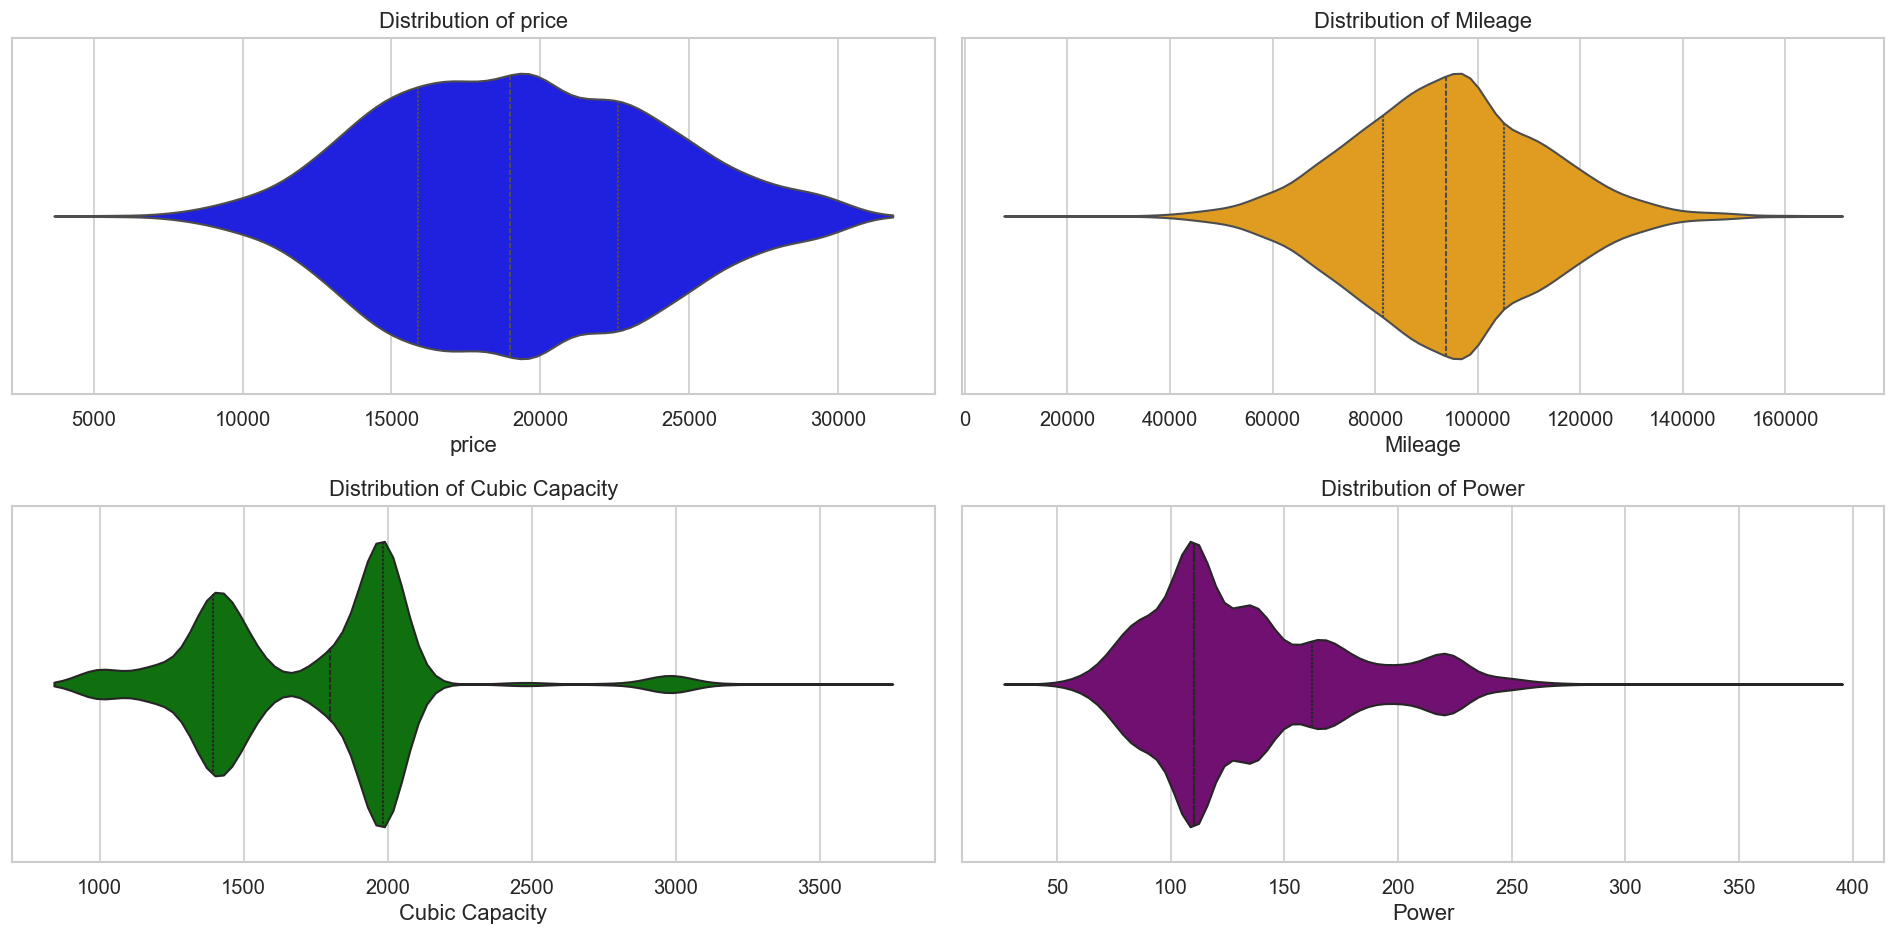

In [23]:
plt.figure(figsize=(16, 8))
for i, (col, color) in enumerate(
    zip(numeric_columns, ["blue", "orange", "green", "purple"]), 1
):
    plt.subplot(2, 2, i)
    sns.violinplot(x=raw_data_cleaned[col], color=color, inner="quartile")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

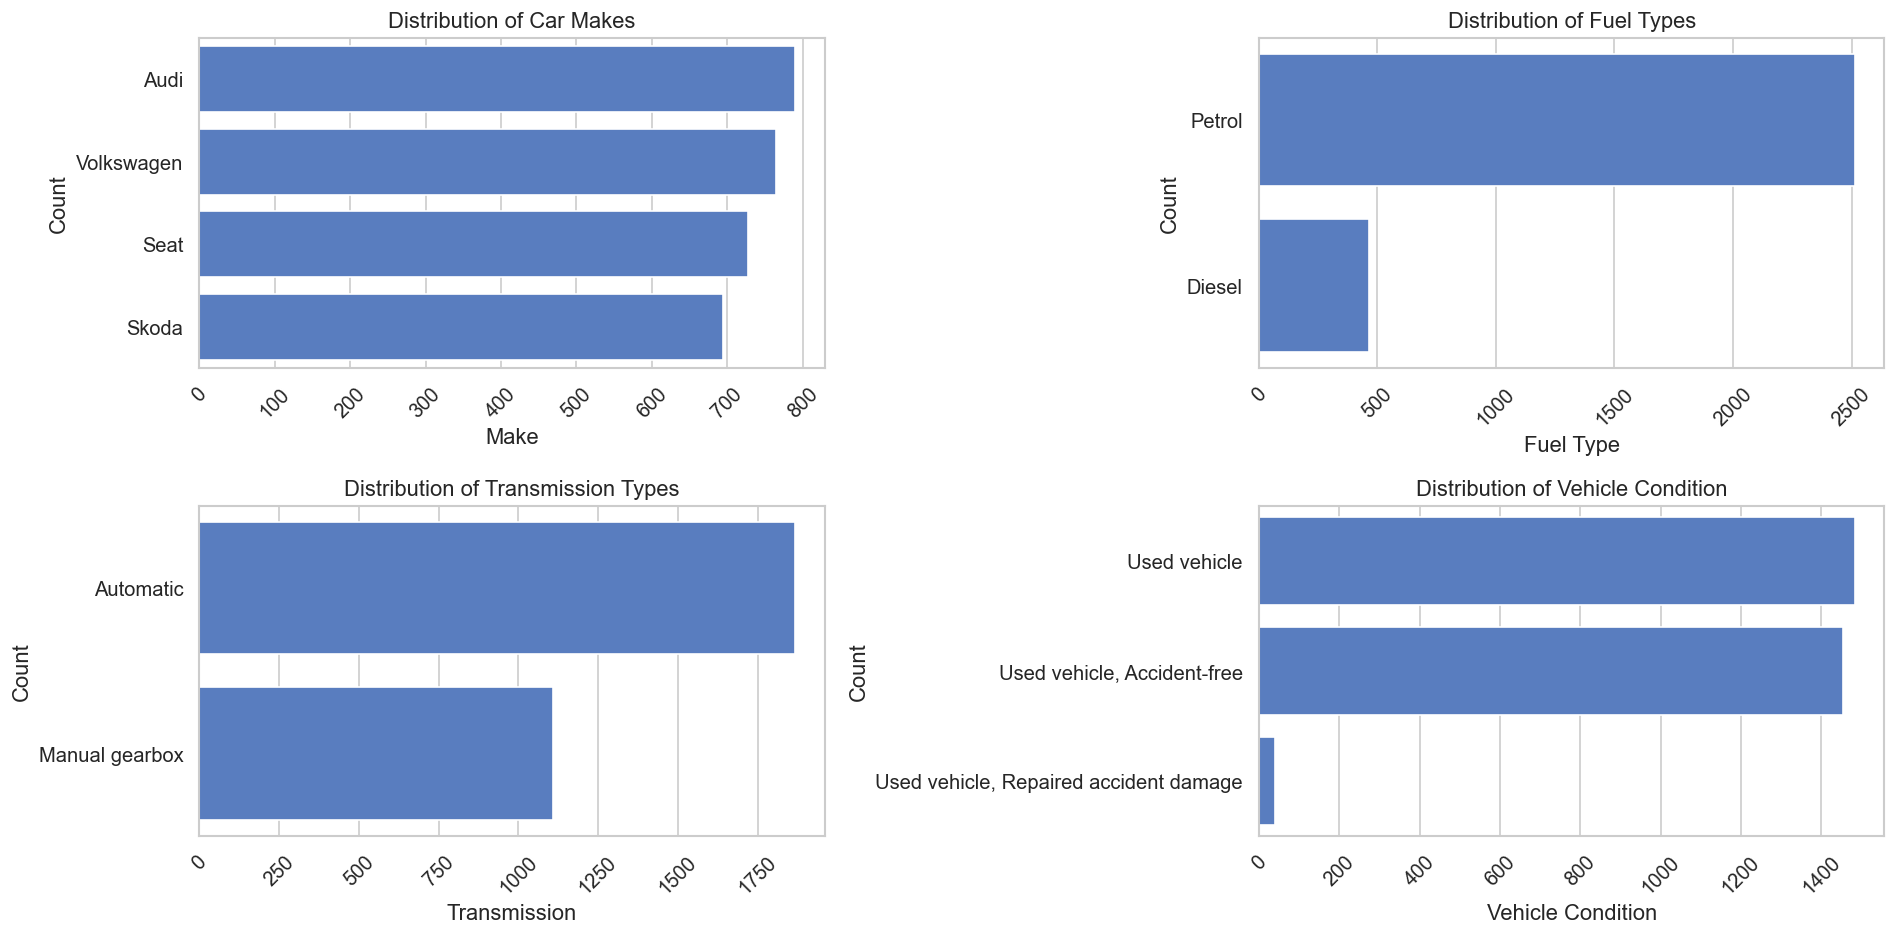

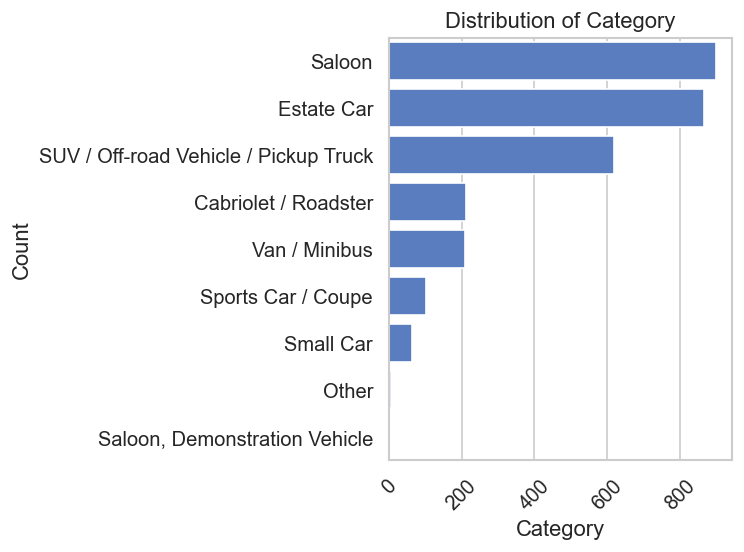

In [24]:
# Univariate Analysis for Key Categorical Features
plt.figure(figsize=(16, 8))

# Make Distribution
plt.subplot(2, 2, 1)
sns.countplot(
    raw_data_cleaned["Make"], order=raw_data_cleaned["Make"].value_counts().index
)
plt.title("Distribution of Car Makes")
plt.xlabel("Make")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Fuel Distribution
plt.subplot(2, 2, 2)
sns.countplot(
    raw_data_cleaned["Fuel"], order=raw_data_cleaned["Fuel"].value_counts().index
)
plt.title("Distribution of Fuel Types")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Transmission Distribution
plt.subplot(2, 2, 3)
sns.countplot(
    raw_data_cleaned["Transmission"],
    order=raw_data_cleaned["Transmission"].value_counts().index,
)
plt.title("Distribution of Transmission Types")
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Vehicle Condition Distribution
plt.subplot(2, 2, 4)
sns.countplot(
    raw_data_cleaned["Vehicle condition"],
    order=raw_data_cleaned["Vehicle condition"].value_counts().index,
)
plt.title("Distribution of Vehicle Condition")
plt.xlabel("Vehicle Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Category Distribution
# plt.subplot(2, 2, 5)
plt.tight_layout()
plt.show()

sns.countplot(
    raw_data_cleaned["Category"],
    order=raw_data_cleaned["Category"].value_counts().index,
)
plt.title("Distribution of Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

price: Skewness=0.12, Kurtosis=-0.51
Shapiro-Wilk test for price: p-value=0.0000


<Figure size 1920x960 with 0 Axes>

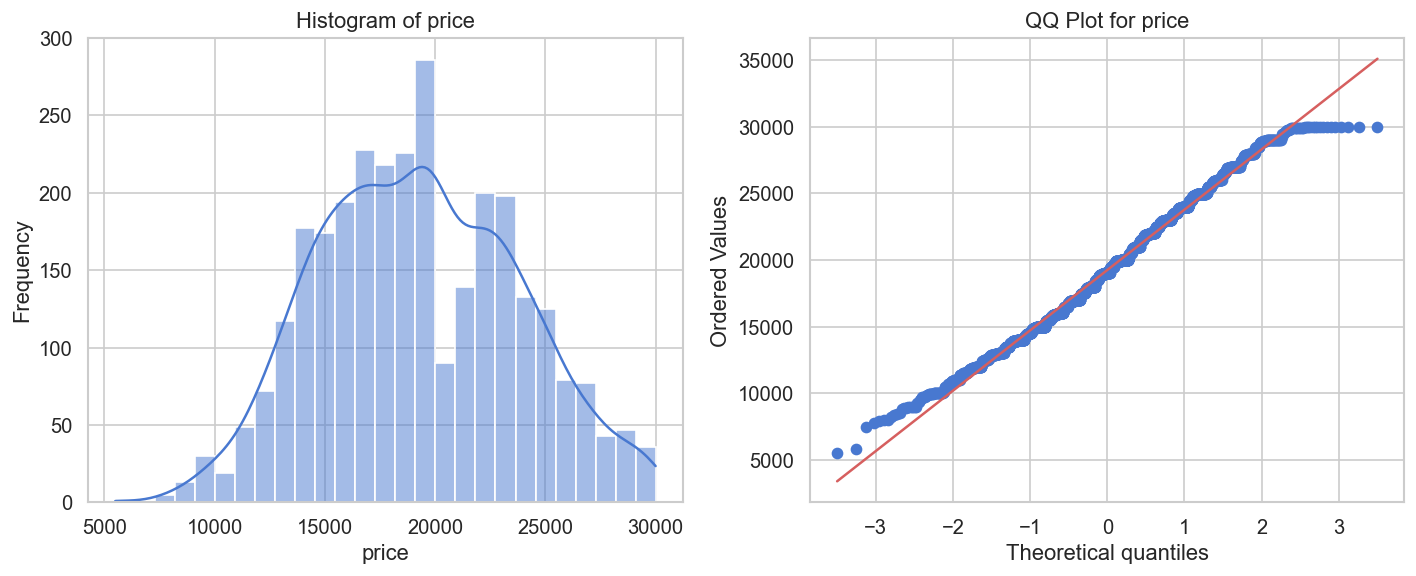

Mileage: Skewness=0.07, Kurtosis=0.27
Shapiro-Wilk test for Mileage: p-value=0.0047


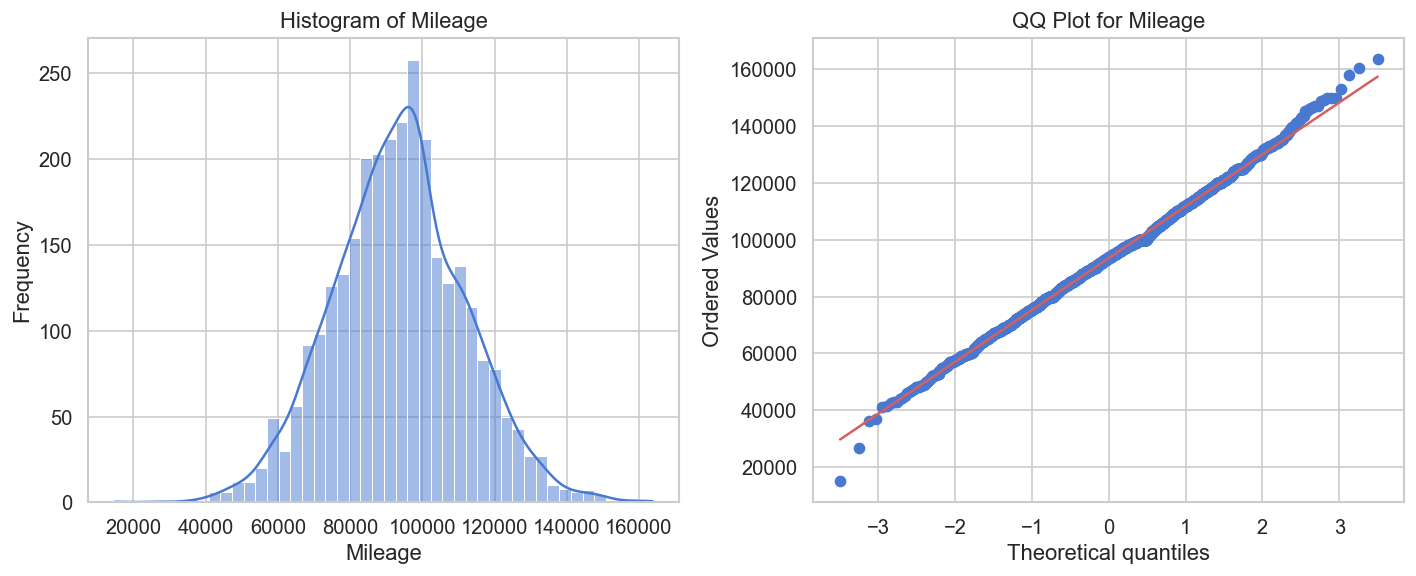

Cubic Capacity: Skewness=0.67, Kurtosis=1.69
Shapiro-Wilk test for Cubic Capacity: p-value=0.0000


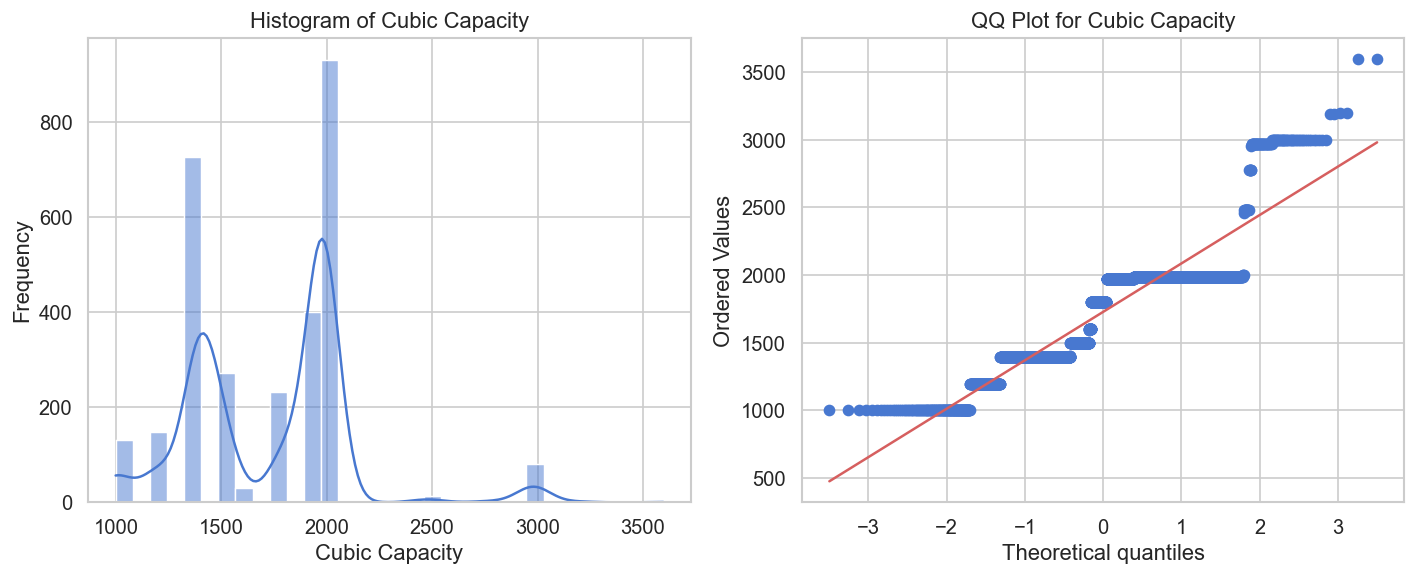

Power: Skewness=0.95, Kurtosis=0.45
Shapiro-Wilk test for Power: p-value=0.0000


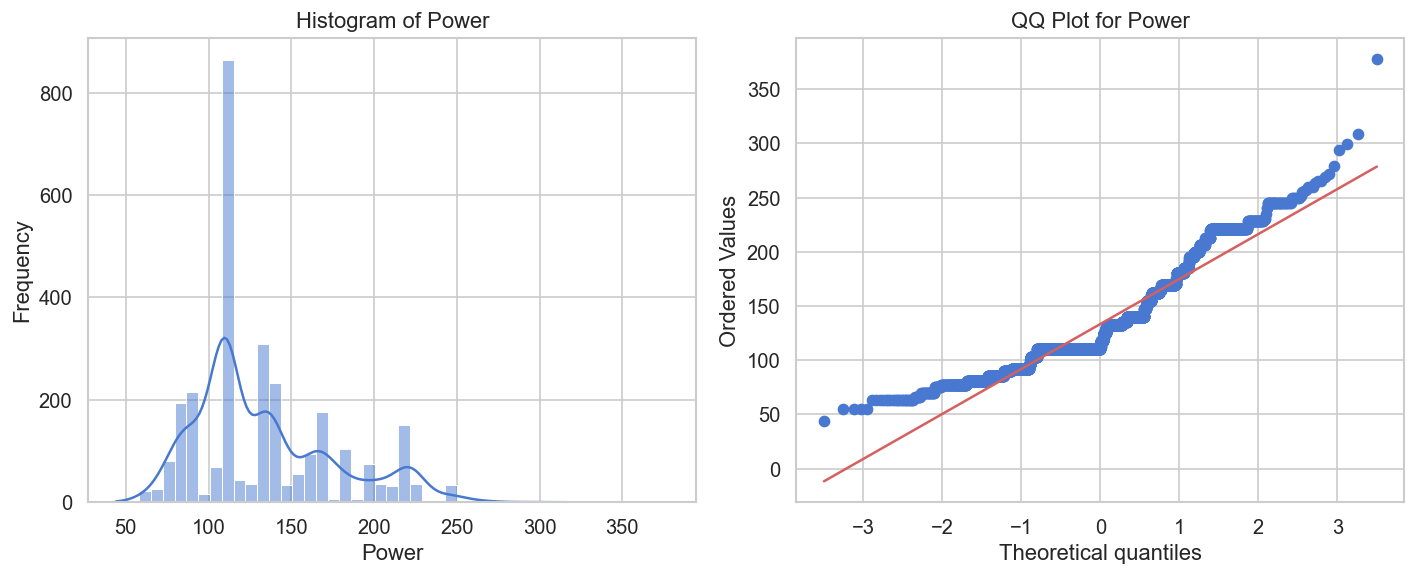

In [25]:
# Distribution Analysis: Skewness, Kurtosis, Normality, QQ Plots
plt.figure(figsize=(16, 8))
for col in numeric_columns:
    print(
        f"{col}: Skewness={skew(raw_data_cleaned[col]):.2f}, Kurtosis={kurtosis(raw_data_cleaned[col]):.2f}"
    )
    stat, p = shapiro(raw_data_cleaned[col].dropna())
    print(f"Shapiro-Wilk test for {col}: p-value={p:.4f}")
    # Show histogram, QQ plot, and print stats for each numeric column in a single row
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histogram
    sns.histplot(raw_data_cleaned[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")
    # QQ Plot
    probplot(raw_data_cleaned[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ Plot for {col}")
    plt.tight_layout()
    plt.show()

## Conclusions from Univariate Analysis
1. Price
    * The price distribution is normal, with most vehicles priced around €20,000.
    * A small number of luxury or high-end vehicles create outliers at the higher end.

2. Mileage
    * Mileage follows a somewhat bell-shaped curve, with most vehicles between 50,000 km and 140,000 km.
    * Few vehicles have extremely low or high mileage, but they may represent unique cases (e.g., new or heavily used vehicles).

3. Power
    * The power distribution shows a clustering around 100–200 kW, which is common for German vehicles.
    * Vehicles with very high power are rare, likely reflecting high-performance or specialty cars.

4. Cubic Capacity
    * The cubic capacity distribution peaks around 1,500–2,000 cc, which aligns with typical engine sizes for German cars.
    * Larger engines (e.g., above 3,000 cc) are less frequent and likely associated with premium or performance cars.

5. Make
    * The number for all 4 makes is roughly the same, which is to be expected since we scraped 1000 listings for each make.
    * Some of the records have been removed due to outliers.

6. Fuel Type
    * There are far more Petrol fueled cars than Diesel fueled ones, again, to be expected since most modern cars come with Petrol engines.

7. Transmission Type
    * More automatic transmission than manual ones, which may also lead to higher prices for those cars.

8. Category
    * Usual categories are the most common ones, including Saloon and Estate with Sports cars and Small hatchbacks being less popular.

## Bivariate Analysis
### Purpose:
   To explore relationships between pairs of variables, such as:

* price vs. Mileage
* price vs. Power
* price vs. categorical variables like Make or Fuel

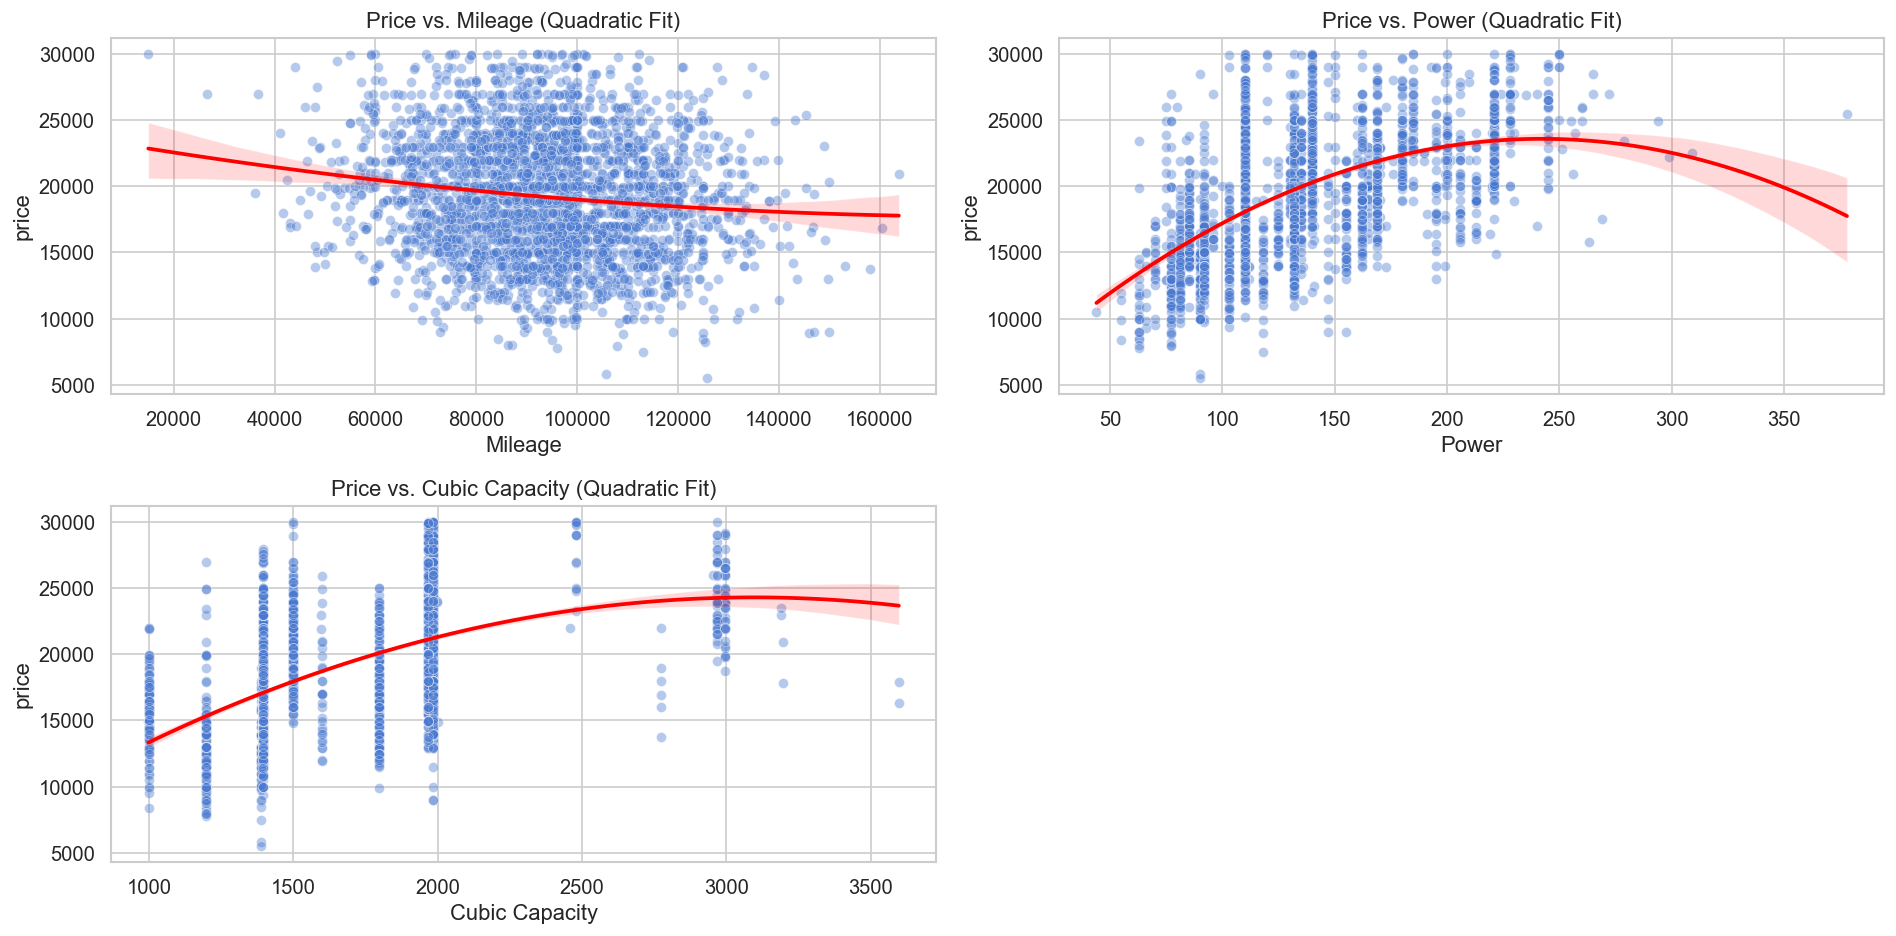

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(data=raw_data_cleaned, x="Mileage", y="price", alpha=0.4)
sns.regplot(
    data=raw_data_cleaned, x="Mileage", y="price", scatter=False, color="red", order=2
)
plt.title("Price vs. Mileage (Quadratic Fit)")

plt.subplot(2, 2, 2)
sns.scatterplot(data=raw_data_cleaned, x="Power", y="price", alpha=0.4)
sns.regplot(
    data=raw_data_cleaned, x="Power", y="price", scatter=False, color="red", order=2
)
plt.title("Price vs. Power (Quadratic Fit)")

plt.subplot(2, 2, 3)
sns.scatterplot(data=raw_data_cleaned, x="Cubic Capacity", y="price", alpha=0.4)
sns.regplot(
    data=raw_data_cleaned,
    x="Cubic Capacity",
    y="price",
    scatter=False,
    color="red",
    order=2,
)
plt.title("Price vs. Cubic Capacity (Quadratic Fit)")

plt.tight_layout()
plt.show()

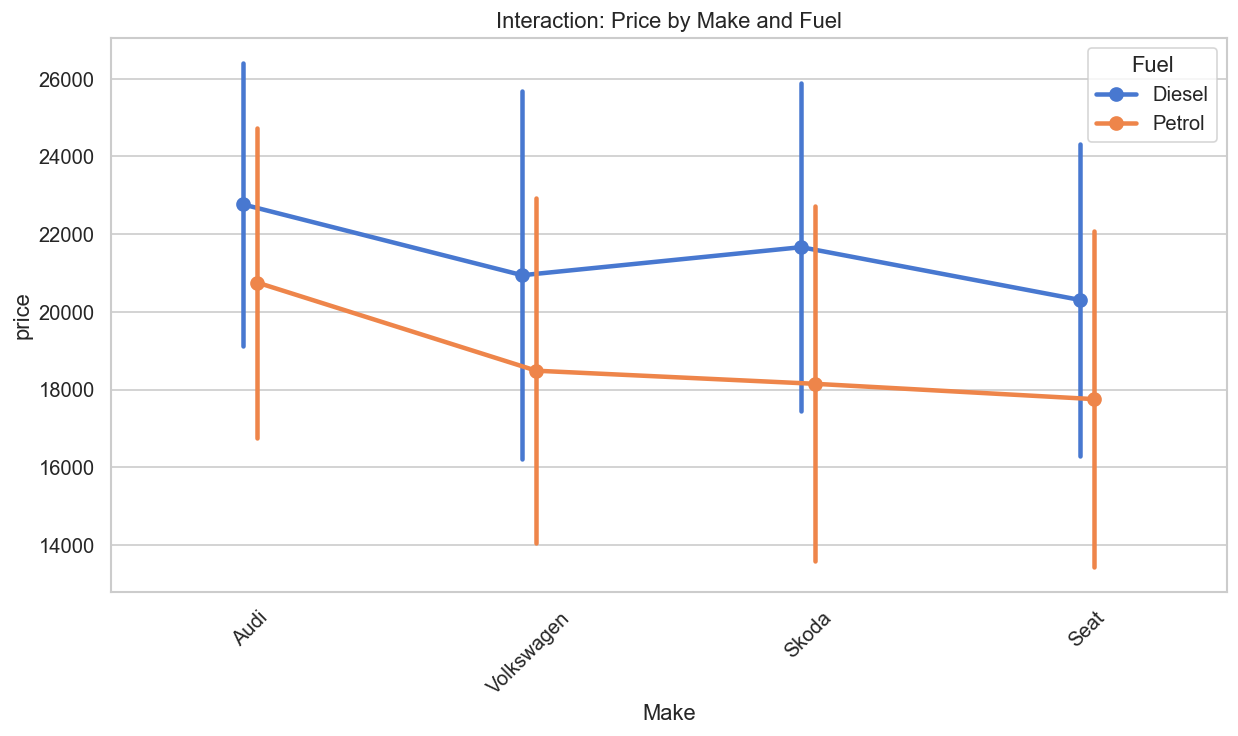

In [27]:
# Interaction Plot: Price by Make and Fuel
plt.figure(figsize=(12, 6))
sns.pointplot(
    data=raw_data_cleaned, x="Make", y="price", hue="Fuel", dodge=True, errorbar="sd"
)
plt.title("Interaction: Price by Make and Fuel")
plt.xticks(rotation=45)
plt.show()

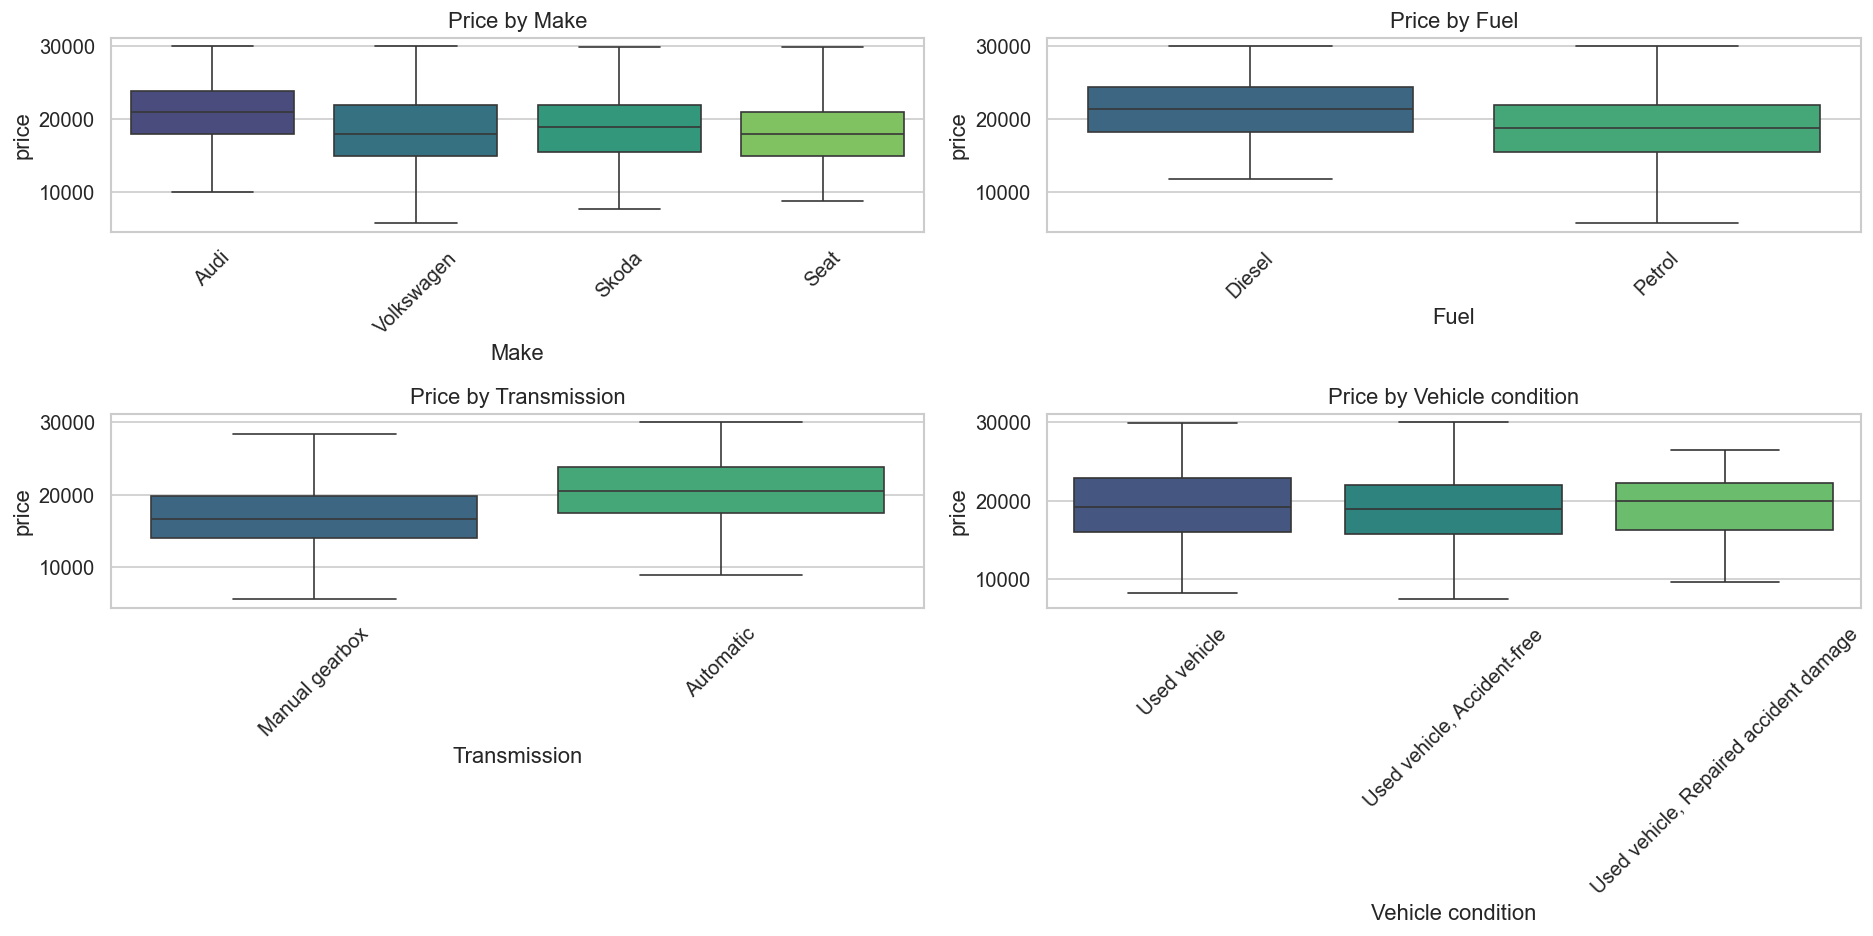

In [28]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(["Make", "Fuel", "Transmission", "Vehicle condition"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        data=raw_data_cleaned, x=col, y="price", palette="viridis", showfliers=False
    )
    plt.title(f"Price by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis
### Purpose:
To identify linear relationships between numeric variables and the target variable (price).

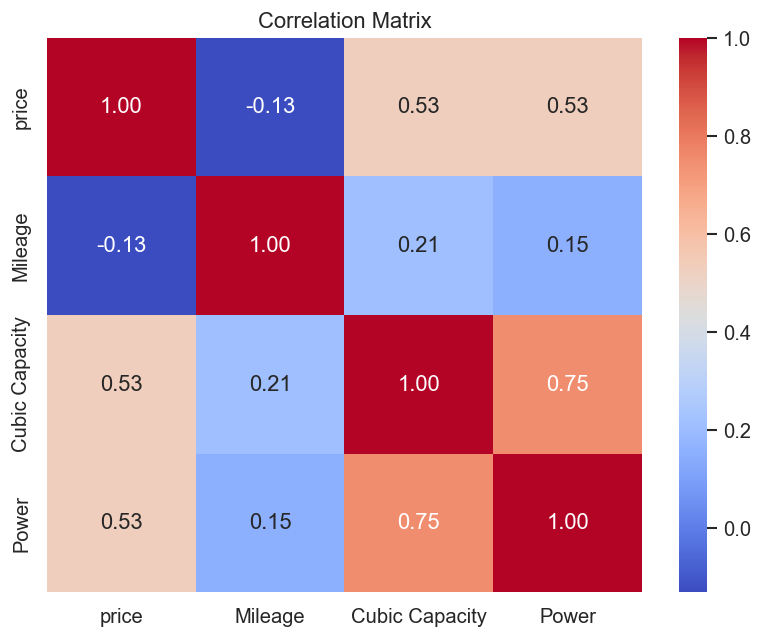

In [29]:
# Correlation Matrix
numeric_cols = ["price", "Mileage", "Cubic Capacity", "Power"]
correlation_matrix = raw_data_cleaned[numeric_cols].corr()

# Heatmap of Correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [30]:
# Statistical Testing
# Kruskal-Wallis for price across Makes
groups = [g["price"].values for _, g in raw_data_cleaned.groupby("Make")]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis test for price across Makes: p-value={p:.4f}")

Kruskal-Wallis test for price across Makes: p-value=0.0000


In [31]:
# Chi-square for Make vs. Fuel
contingency = pd.crosstab(raw_data_cleaned["Make"], raw_data_cleaned["Fuel"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square test for Make vs. Fuel: p-value={p:.4f}")

Chi-square test for Make vs. Fuel: p-value=0.0003


In [32]:
# VIF Analysis
X = raw_data_cleaned[["Mileage", "Power", "Cubic Capacity"]].copy()
X = X.fillna(X.median())
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Table:\n", vif_data)

VIF Table:
           feature        VIF
0         Mileage  15.236202
1           Power  23.962877
2  Cubic Capacity  40.722210


## Conclusions
1. Bivariate Analysis

* Price vs. Mileage:
    * Clear negative relationship: cars with higher mileage generally have lower prices.
    * A few outliers exist (e.g., low-price cars with very low mileage).
* Price vs. Power:
    * Positive relationship: cars with higher power (kW) tend to have higher prices.
    * The trend weakens for vehicles with extremely high power.
* Price vs. Cubic Capacity:
    * Moderate positive relationship: larger engines generally correlate with higher prices.
    * A notable clustering around common cubic capacities (e.g., ~2,000 cc).

2. Price by Categorical Features

* Price by Make:
    * Luxury brands like Audi and BMW have higher median prices compared to Skoda and Volkswagen.
    * Price variance is highest for Audi, reflecting its diverse product range.
* Price by Fuel Type:
    * Diesel cars tend to have slightly higher prices compared to petrol cars.
    * Alternative fuels (e.g., hybrid) appear less frequently but with higher prices.
* Price by Transmission:
    * Automatic vehicles have higher median prices compared to manual ones.
    * Likely reflects demand and technology differences.

3. Correlation Analysis

* Strongest Correlations:
    * Power has a moderately strong positive correlation with price (~0.6).
    * Mileage has a moderate negative correlation with price (~-0.5).
    * Cubic Capacity shows a weaker positive correlation with price (~0.5).

* Key Insights:
    * Engine-related metrics (Power, Cubic Capacity) and Mileage are important predictors of price.
    * Multicollinearity among numeric variables appears limited, which is ideal for modeling.

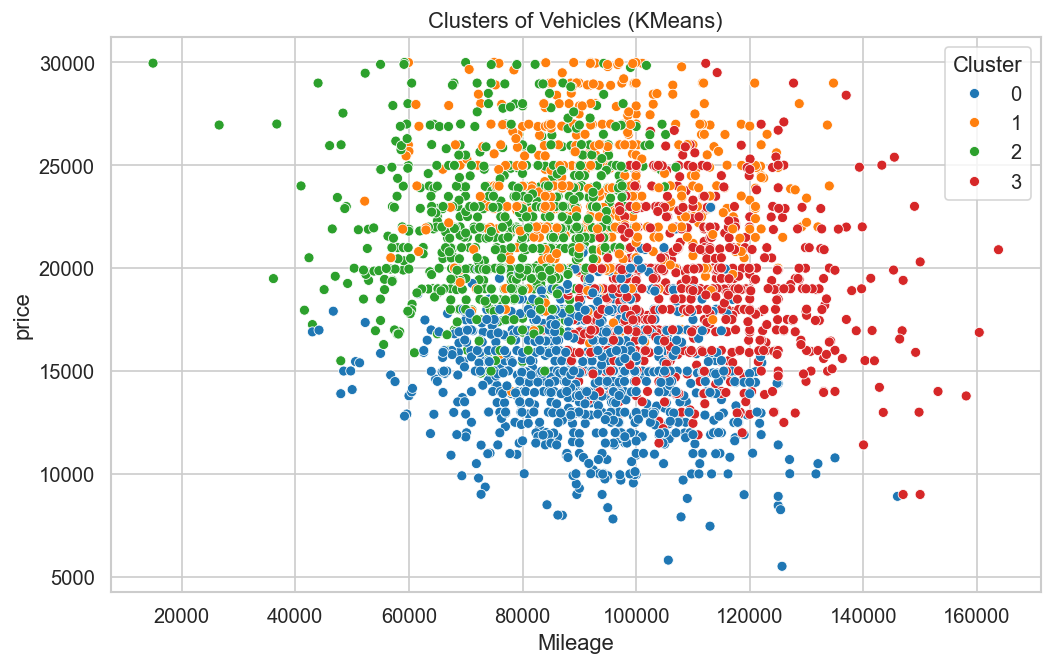

In [33]:
# Clustering for Unsupervised Exploration
scaler = StandardScaler()
X_scaled = scaler.fit_transform(raw_data_cleaned[numeric_columns])
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
raw_data_cleaned["Cluster"] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=raw_data_cleaned["Mileage"],
    y=raw_data_cleaned["price"],
    hue=raw_data_cleaned["Cluster"],
    palette="tab10",
)
plt.title("Clusters of Vehicles (KMeans)")
plt.show()

## Feature Engineering

* Derived Features:
    * Vehicle Age: Extracted from the First Registration column.
    * Mileage per Year: Normalized mileage based on vehicle age.

* Encoded Features:
    * Categorical columns (Make, Fuel, Transmission, Drive type) were one-hot encoded.
    * Other categorical columns containing a high percentage of distinct values which are not relevant for the analysis (Interior Color, for example, we dropped)

* Transformed Features:
    * Log transformations applied to price (Log Price) and Mileage (Log Mileage) to handle skewness.

* Standardized Features:
    * Key numeric features (Mileage, Power, Cubic Capacity, Vehicle Age, Mileage per Year) were standardized to ensure consistent scaling.

In [34]:
# Derive Features
current_year = datetime.now().year
raw_data_cleaned["First Registration Year"] = (
    raw_data_cleaned["First Registration"].str.extract(r"(\d{4})").astype(float)
)
raw_data_cleaned["Vehicle Age"] = (
    current_year - raw_data_cleaned["First Registration Year"]
)
raw_data_cleaned["Mileage per Year"] = (
    raw_data_cleaned["Mileage"] / raw_data_cleaned["Vehicle Age"]
)

# Encoding Categorical Variables
categorical_columns_to_encode = [
    "Vehicle condition",
    "Make",
    "Category",
    "Door Count",
    "Emission Class",
    "Climatisation",
    "Parking sensors",
    "Airbags",
    "Colour",
    "Fuel",
    "Transmission",
]

# Perform one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_columns = pd.DataFrame(
    encoder.fit_transform(raw_data_cleaned[categorical_columns_to_encode]),
    columns=encoder.get_feature_names_out(categorical_columns_to_encode),
    index=raw_data_cleaned.index,
)

# Drop all remaining categorical columns
categorical_columns_to_drop = raw_data_cleaned.select_dtypes(include="object").columns
raw_data_encoded = pd.concat(
    [raw_data_cleaned.drop(columns=categorical_columns_to_drop), encoded_columns],
    axis=1,
)

# Step 3: Handle Skewness
raw_data_encoded["Log Price"] = np.log1p(raw_data_encoded["price"])
raw_data_encoded["Log Mileage"] = np.log1p(raw_data_encoded["Mileage"])

# Step 4: Standardization
numeric_features = [
    "Mileage",
    "Power",
    "Cubic Capacity",
    "Vehicle Age",
    "Mileage per Year",
]
scaler = StandardScaler()
raw_data_encoded[numeric_features] = scaler.fit_transform(
    raw_data_encoded[numeric_features]
)

# Step 5: Drop all rows with missing values
raw_data_encoded = raw_data_encoded.dropna()

print("Feature Engineering Summary:")
print(
    f"- Encoded Features: {encoder.get_feature_names_out(categorical_columns_to_encode).tolist()}"
)
print(f"- Dropped Columns: {categorical_columns_to_drop.tolist()}")
print("Transformed Dataset:")
print(raw_data_encoded.info())

Feature Engineering Summary:
- Encoded Features: ['Vehicle condition_Used vehicle', 'Vehicle condition_Used vehicle, Accident-free', 'Vehicle condition_Used vehicle, Repaired accident damage', 'Make_Audi', 'Make_Seat', 'Make_Skoda', 'Make_Volkswagen', 'Category_Cabriolet / Roadster', 'Category_Estate Car', 'Category_Other', 'Category_SUV / Off-road Vehicle / Pickup Truck', 'Category_Saloon', 'Category_Saloon, Demonstration Vehicle', 'Category_Small Car', 'Category_Sports Car / Coupe', 'Category_Van / Minibus', 'Door Count_2/3', 'Door Count_4/5', 'Door Count_nan', 'Emission Class_Euro 6e', 'Emission Class_Euro4', 'Emission Class_Euro5', 'Emission Class_Euro6', 'Emission Class_Euro6c', 'Emission Class_Euro6d', 'Emission Class_Euro6d-TEMP', 'Emission Class_nan', 'Climatisation_A/C (man.)', 'Climatisation_Automatic air conditioning', 'Climatisation_Automatic climatisation, 2 zones', 'Climatisation_Automatic climatisation, 3 zones', 'Climatisation_Automatic climatisation, 4 zones', 'Climati

In [35]:
# Save the final dataset to a CSV file
raw_data_encoded.to_csv("./data/processed_data.csv", index=False)